<a href="https://colab.research.google.com/github/connor-verheyen/COVID19_IndoorRH/blob/main/supplementary_analysis/Supplementary_Section_04__Validating_Humidity_Extrapolation_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import basic libraries 

import pandas as pd 

import numpy as np 

import math 

import matplotlib.pyplot as plt 

import matplotlib.dates as mdates

%matplotlib inline

import scipy

import seaborn as sns

# Set seaborn plotting context 
sns.set(context='talk',style='ticks')

### Functions for Extrapolation

In [ ]:
# Function for calculating the relative humidity from the ambient temperature and dewpoint 
# Values are calculated using the August-Roche-Magnus approximation, from: "Calculate Temperature, Dewpoint, or Relative Humidity" prepared by Brian McNoldy
def rel_hum_calc(Temp, Dewpoint):
    RelativeHumidity =100*(math.exp((17.625*Dewpoint)/(243.04+Dewpoint))/math.exp((17.625*Temp)/(243.04+Temp)))
    return RelativeHumidity

# Function for calculating the absolute humidity from the ambient temperature and relative humidity 
# Values are calculated in g/m^3, using formula from: "How to convert relative humidity to absolute humidity" on the CarnotCycle blog on thermodynamics
def abs_hum_calc(Temp, RelHum):
    AbsoluteHumidity = (6.112*math.exp((17.625*Temp)/(Temp+243.04))*RelHum*2.1674)/(273.16+Temp)
    return AbsoluteHumidity

# Function for calculating the indoor relative humidity from the "thermal comfort" temperature and absolute humidity 
# Values are calculated using formula and saturation vd best-fit provided by Georgia State's HyperPhysics site
def indoor_rh_calc(T_actual, T_comfort, AbsHum): 
    if T_actual < T_comfort: 
        SatVaporDensity = 5.018 + 0.32321*T_comfort + 8.1847e-3*T_comfort**2 + 3.1243e-4*T_comfort**3 #in g/m3
    else: 
        SatVaporDensity = 5.018 + 0.32321*T_actual + 8.1847e-3*T_actual**2 + 3.1243e-4*T_actual**3 #in g/m3

    ActualVaporDensity = AbsHum #in g/m3
    RelativeHumidity = (ActualVaporDensity/SatVaporDensity)*100
    return RelativeHumidity

### August-Roche-Magnus Approximation vs. Clausius-Clayperon Solution

In [ ]:
# Function for vapor pressure (in Pa) using analytical solution of cc equation 
def cc(e0,L,Rv,T0,T):
    es = e0 * math.exp( (L/Rv) * ( (1/T0) - (1/(T+273.15) )))
    return es

# Function for approximating the specific latent heat of condensation of water in the temperature range from -25C to 40C
def Lwater(T):
  Lwater = (2500.8 - 2.36*T + 0.0016*T**2 - 0.00006*T**3) * 1000 # Multiply by 1000 to get in J/kg
  return Lwater

# Function for vapor pressure (in Pa) using August-Roche-Magnus approximation 
def magnus(T): 
  es = 0.61094*math.exp( (17.625 * T) / (T + 243.04) ) *1000 # Multiply by 1000 to get Pa 
  return es

In [ ]:
def pct_error(A,B):
  pct_error = ((A-B)/A)*100
  return pct_error

def abs_error(A,B):
  abs_error = (A-B)
  return abs_error

In [ ]:
# Range of temperature values 
x=np.arange(-10,40)

# Analytical solution to CC relation
e0=611.65; L=Lwater(0); Rv=461.524; T0=273.15
ycc=[]
for xval in x: 
  yval = cc(e0=e0,L=L,Rv=Rv,T0=T0,T=xval)
  ycc.append(yval)
ycc = np.array(ycc)

# August-Magnus-Roche approximation 
ymag = []
for xval in x: 
  yval = magnus(xval)
  ymag.append(yval)
ymag = np.array(ymag)

In [ ]:
# Initialize lists to store all of the RH values for each formula for future calculations 
RHcc=[]; RHmag=[];

# Initialize an empty dataframe where all of the indices are temperature values and all of the columns are dewpoint values 
df = pd.DataFrame(index=np.arange(-10,40+1),columns=np.arange(-20,40+1))

# Copy the empty dataframe so you have one for each of the formulas 
dfcc=df.copy(); dfmag=df.copy(); 

# Go through each of the temperature values 
for Temp in df.index:

  # Go through each of the dewpoint values 
  for Dewpoint in df.columns:

    # Check to make sure the dewpoint is below the temp (otherwise it's just NaN)
    if Dewpoint < Temp:

      # Calculate e (actual vapor pressure, based on the dewpoint)
      # Calculate es (saturation vapor pressure, based on the temperature)
      # Calculate RH (relative humidity, comparison of actual vapor pressure and saturation vapor pressure) 
      # Save all the values and add them to the dataframes 

      e0=611.65; L=Lwater(0); Rv=461.524; T0=273.15
      e=cc(e0=e0,L=L,Rv=Rv,T0=T0,T=Dewpoint); es=cc(e0=e0,L=L,Rv=Rv,T0=T0,T=Temp); RH = e/es*100
      RHcc.append(RH)
      dfcc.loc[Temp,Dewpoint] = RH

      e=magnus(Dewpoint); es=magnus(Temp); RH = e/es*100
      RHmag.append(RH)
      dfmag.loc[Temp,Dewpoint] = RH

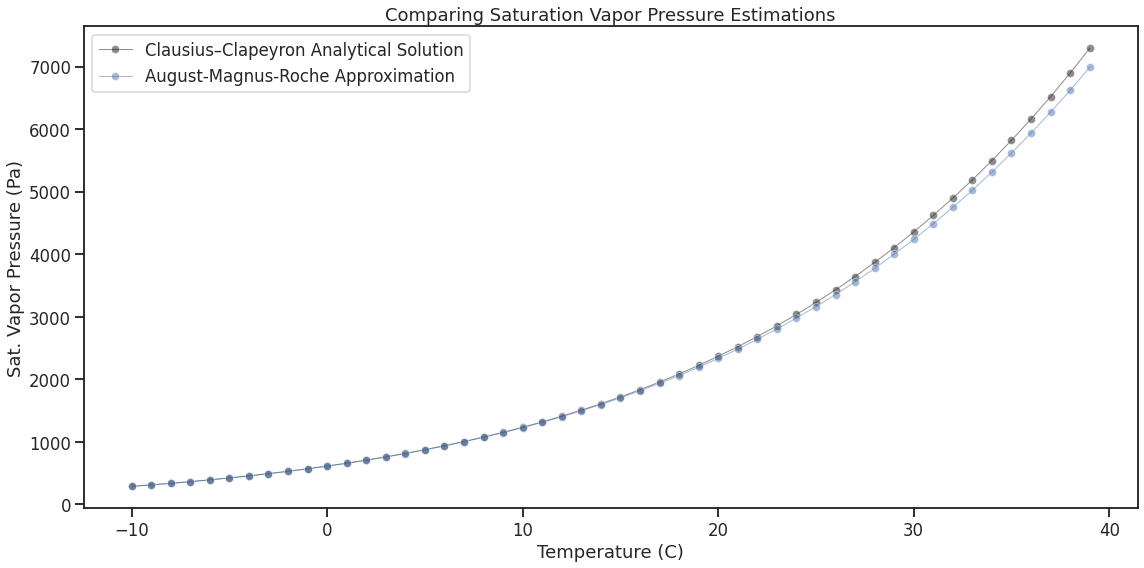

In [ ]:
fig,ax=plt.subplots(figsize=(16,8))

alpha = 0.5; s=8; linewidth=1; marker='o'

sns.lineplot(x=x,y=ycc,label='Clausius–Clapeyron Analytical Solution',ax=ax,alpha=alpha,linewidth=linewidth,marker=marker,color='k',markersize=s)
sns.lineplot(x=x,y=ymag,label='August-Magnus-Roche Approximation',ax=ax,alpha=alpha,linewidth=linewidth,marker=marker,color='b',markersize=s)

ax.set_title('Comparing Saturation Vapor Pressure Estimations')
ax.set_xlabel('Temperature (C)'); ax.set_ylabel('Sat. Vapor Pressure (Pa)')

fig.tight_layout()

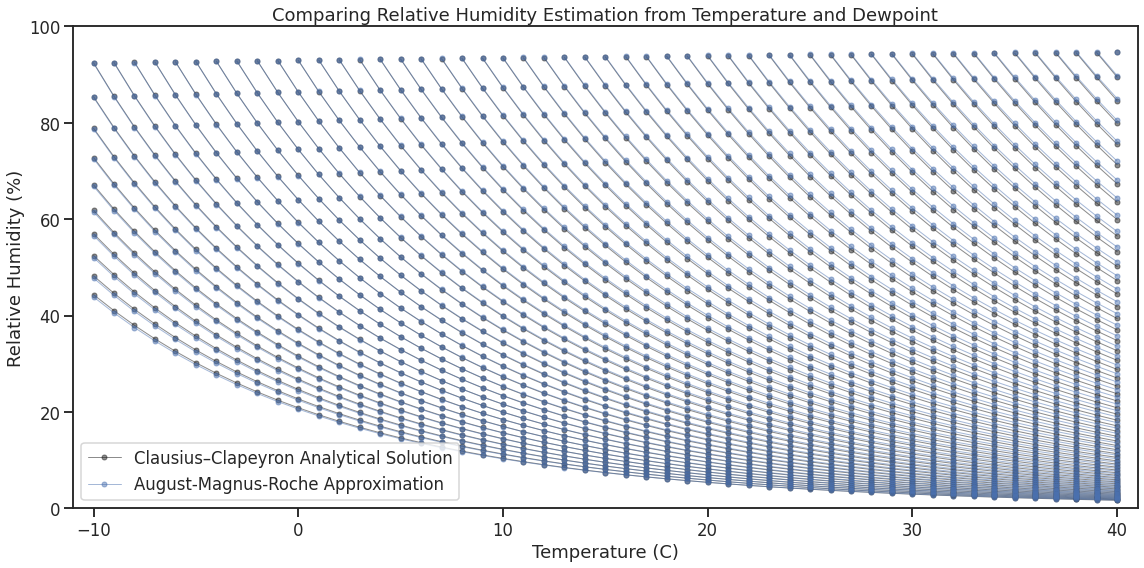

In [ ]:
fig,ax=plt.subplots(figsize=(16,8))

alpha = 0.5; s=5; linewidth=1; marker='o'

ax.plot(dfcc,color='k',label='CC',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s)
ax.plot(dfmag,color='b',label='CC',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s)

ax.set_ylim(0,100); ax.set_ylabel('Relative Humidity (%)')
ax.set_xlim(-11,41); ax.set_xlabel('Temperature (C)')
ax.set_title('Comparing Relative Humidity Estimation from Temperature and Dewpoint')

from matplotlib.lines import Line2D
customlegend = [Line2D([0], [0],color='k',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='b',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),]

ax.legend(customlegend, ['Clausius–Clapeyron Analytical Solution', 
                         'August-Magnus-Roche Approximation'
                         ],loc='lower left')

fig.tight_layout()

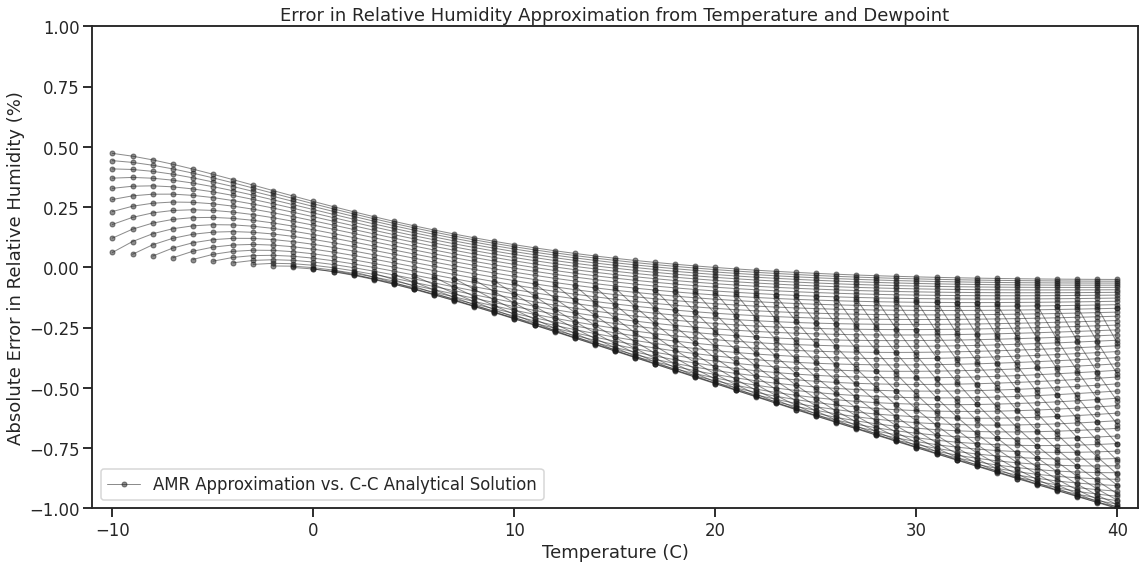

In [ ]:
fig,ax=plt.subplots(figsize=(16,8))

alpha = 0.5; s=5; linewidth=1; marker='o'

ax.plot(abs_error(dfcc,dfmag),color='k',label='CC',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s)

ax.set_ylim(-1,1); ax.set_ylabel('Absolute Error in Relative Humidity (%)')
ax.set_xlim(-11,41); ax.set_xlabel('Temperature (C)')
ax.set_title('Error in Relative Humidity Approximation from Temperature and Dewpoint')

from matplotlib.lines import Line2D
customlegend = [Line2D([0], [0],color='k',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),]

ax.legend(customlegend, ['AMR Approximation vs. C-C Analytical Solution', ],loc='lower left')

fig.tight_layout()

In [ ]:
# Compute the mean absolute error 
print('The mean absolute error in RH between the Clausius–Clapeyron Analytical Solution and the August-Magnus-Roche Approximation:')
print(round(abs(np.mean(abs_error(dfcc.unstack().dropna().values, dfmag.unstack().dropna().values))),2),'+/-',round(abs(np.std(abs_error(dfcc.unstack().dropna().values, dfmag.unstack().dropna().values))),2))

# Compute the mean percent error 
print('\nThe mean percent error in RH between the Clausius–Clapeyron Analytical Solution and the August-Magnus-Roche Approximation:')
print(round(abs(np.mean(pct_error(dfcc.unstack().dropna().values, dfmag.unstack().dropna().values))),2),'+/-',round(abs(np.std(pct_error(dfcc.unstack().dropna().values, dfmag.unstack().dropna().values))),2))

The mean absolute error in RH between the Clausius–Clapeyron Analytical Solution and the August-Magnus-Roche Approximation:
0.26 +/- 0.31

The mean percent error in RH between the Clausius–Clapeyron Analytical Solution and the August-Magnus-Roche Approximation:
1.23 +/- 1.35


### Boston Hospital Study and Boston Weather Data

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Boston_Weather_For_Comparison.csv'

# Read in the csv and parse the date and time  
bos_outdoor = pd.read_csv(filename,parse_dates=[[0,1]]).drop(columns=['Weather','Wind','Barometer']).rename(columns={'Date_Time':'DateTime'})


# # Read in the excel 
# bos_outdoor = pd.read_excel('Boston_Weather_For_Comparison.xlsx').drop(columns=['Weather','Wind','Barometer'])

# from datetime import datetime, date, timedelta 

# # Make a datetime column that combines the date column and time column 
# bos_outdoor.loc[:,'DateTime'] = bos_outdoor.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# # Multiply humidity by 100 to get it in percent
# bos_outdoor.loc[:,'Humidity'] = bos_outdoor['Humidity'].apply(lambda humidity: humidity*100)


# Get humidity in the correct data format 
bos_outdoor.loc[:,'Humidity'] = bos_outdoor['Humidity'].str.rstrip('%').astype('float')#.apply(lambda humidity: humidity*100)

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
bos_outdoor.loc[:,'Temp_C'] = bos_outdoor['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Check the df
bos_outdoor.head()

DateTime Temp_F  Humidity    Temp_C
0 2020-03-30 07:54:00    39       93.0  3.888889
1 2020-03-30 08:54:00    39       93.0  3.888889
2 2020-03-30 09:54:00    40       93.0  4.444444
3 2020-03-31 07:54:00    34       82.0  1.111111
4 2020-03-31 08:12:00    35       78.0  1.666667

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Table_T_RH_DewPoint_BostonWeather_IndoorHospitalData.csv'

# Read in the csv
bos_indoor=pd.read_csv(filename)

# # Read in the excel 
# bos_indoor = pd.read_excel('Table_T_RH_DewPoint_BostonWeather.xlsx',sheet_name='IndoorHospitalData')

# Check the df
bos_indoor.head()

Location  IndoorT1  ...  IndoorRH2  IndoorRH3
0           Academic offices        21  ...         15         19
1        Common office areas        22  ...         18         23
2   Low traffic public areas        23  ...         24         28
3  High traffic public areas        22  ...         24         28
4            Operating rooms        21  ...         25         32

[5 rows x 7 columns]

In [ ]:
# Calculate the outdoor absolute humidity 
bos_outdoor.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) for temp, relhum in 
                                 zip(bos_outdoor['Temp_C'], bos_outdoor['Humidity'])]

Thermal_Comfort_Temp = 21 # degrees C

# Extrapolate the indoor relative humidity, assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
bos_outdoor.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) for actualtemp, abshum in 
                                      zip(bos_outdoor['Temp_C'], bos_outdoor['out_AH_1'])]

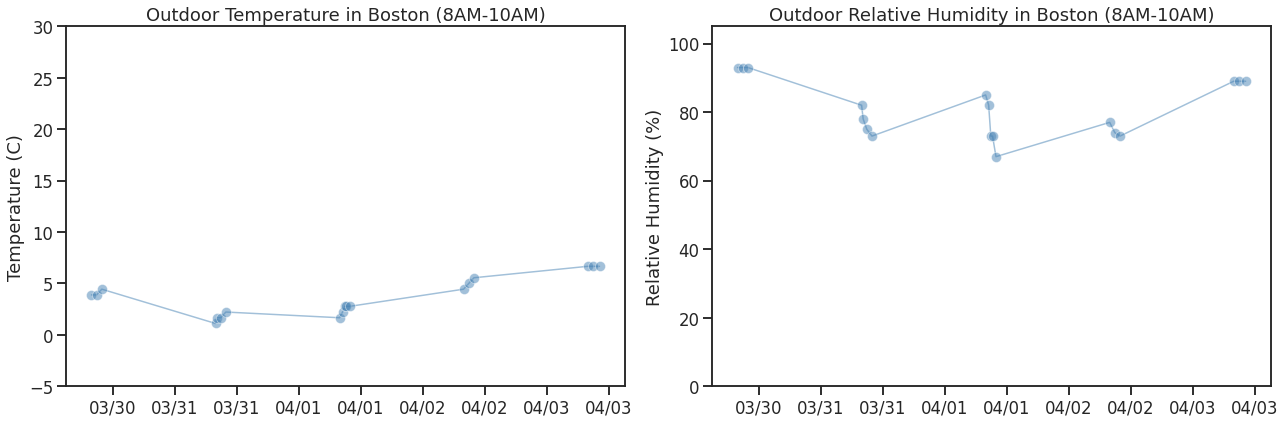

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=10; linewidth=1.5; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='Temp_C',data=bos_outdoor,label='Temp',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color)

sns.lineplot(x='DateTime',y='Humidity',data=bos_outdoor,label='Humidity',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color)

[ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d")) for ax in plt.gcf().axes]
#[ax.tick_params(axis='x', rotation=10) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

ax[0].set_ylabel('Temperature (C)')
ax[0].set_title('Outdoor Temperature in Boston (8AM-10AM)')

ax[1].set_ylabel('Relative Humidity (%)')
ax[1].set_title('Outdoor Relative Humidity in Boston (8AM-10AM)')

ax[0].set_ylim(-5,30); ax[1].set_ylim(0,105)

[ax.get_legend().remove() for ax in plt.gcf().axes]
#ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

fig.tight_layout()

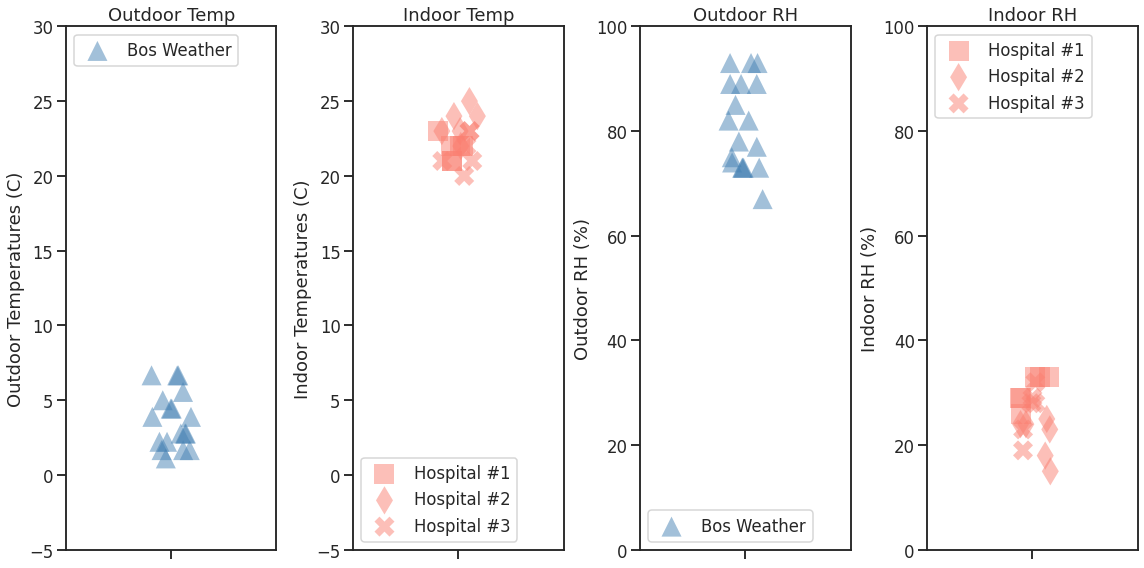

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.5; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.stripplot(y='Temp_C',data=bos_outdoor,label='Bos Weather',ax=ax[0],color=outdoor_color,s=s,alpha=alpha,marker='^',jitter=jitter)

sns.stripplot(y='IndoorT1',data=bos_indoor,label='Hospital #1',ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='s',jitter=jitter)
sns.stripplot(y='IndoorT2',data=bos_indoor,label='Hospital #2',ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='d',jitter=jitter)
sns.stripplot(y='IndoorT3',data=bos_indoor,label='Hospital #3',ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='X',jitter=jitter)

sns.stripplot(y='Humidity',data=bos_outdoor,label='Bos Weather',ax=ax[2],color=outdoor_color,s=s,alpha=alpha,marker='^',jitter=jitter)

sns.stripplot(y='IndoorRH1',data=bos_indoor,label='Hospital #1',ax=ax[3],color=indoor_color,s=s,alpha=alpha,marker='s',jitter=jitter)
sns.stripplot(y='IndoorRH2',data=bos_indoor,label='Hospital #2',ax=ax[3],color=indoor_color,s=s,alpha=alpha,marker='d',jitter=jitter)
sns.stripplot(y='IndoorRH3',data=bos_indoor,label='Hospital #3',ax=ax[3],color=indoor_color,s=s,alpha=alpha,marker='X',jitter=jitter)

ax[0].set_ylim(-5,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,100); ax[3].set_ylim(0,100); 

ax[0].legend(loc='upper left'); ax[0].set_ylabel('Outdoor Temperatures (C)'); ax[0].set_title('Outdoor Temp')
ax[1].legend(loc='lower left'); ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp')
ax[2].legend(loc='lower left'); ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH')
ax[3].legend(loc='upper left'); ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH')

fig.tight_layout()

In [ ]:
#bos_outdoor['in_RH_CALC_1'].reset_index().rename(columns={'in_RH_CALC_1': 'Indoor RH', 'index': 'Name'})

In [ ]:
# Turn all of the indoor RH measurements (hosp#1, hosp#2, hosp#3) into a long-form dataframe
indoor_longRH = bos_indoor.iloc[:,-3:].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'})
indoor_longT = bos_indoor.iloc[:,1:-3].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'})

# If you want all of the indoor values to have the same name (combine data from all 3 hospitals)
indoor_longRH_same = indoor_longRH.copy()
indoor_longRH_same.loc[:,'RHName'] = 'Indoor'

indoor_longT_same = indoor_longT.copy()
indoor_longT_same.loc[:,'TName'] = 'Indoor'

# Reformat the extrapolated (outdoor to indoor) one for concatenation
outdoor_long = bos_outdoor['in_RH_CALC_1'].reset_index().rename(columns={'in_RH_CALC_1': 'Indoor RH', 'index': 'RHName'})
outdoor_long.loc[:,'RHName'] = 'Outdoor'

# Concatenate the dataframes
in_vs_out = pd.concat([indoor_longRH,indoor_longT,outdoor_long])#,axis=1)
in_vs_out_same = pd.concat([indoor_longRH_same,indoor_longT_same,outdoor_long])#,axis=1)

# Add a row for the assumed temperature 
assumed = pd.DataFrame(columns=in_vs_out_same.columns,data=[[np.nan,np.nan,'Assumed',21]])
in_vs_out_same = in_vs_out_same.append(assumed)

#in_vs_out

In [ ]:
# fig,ax = plt.subplots(figsize=(8,8))

# alpha = 0.5; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.boxplot(x='RHName',y='Indoor RH', data=in_vs_out, width=width,linewidth=linewidth)

# ax.set_ylim(0,100); ax.set_ylabel('Indoor Relative Humidity (%)'); ax.set_xlabel('')
# ax.set_title('Extrapolated Indoor RH vs. Measured Indoor RH')
# ax.set_xticklabels(['Hospital #1\n (Measured)','Hospital #2\n (Measured)','Hospital #3\n (Measured)','Extrapolated',])
    
# [patch.set_alpha(alpha) for patch in ax.artists]
# [ax.artists[i].set_facecolor(indoor_color) for i in range(0,4)]

# fig.tight_layout()

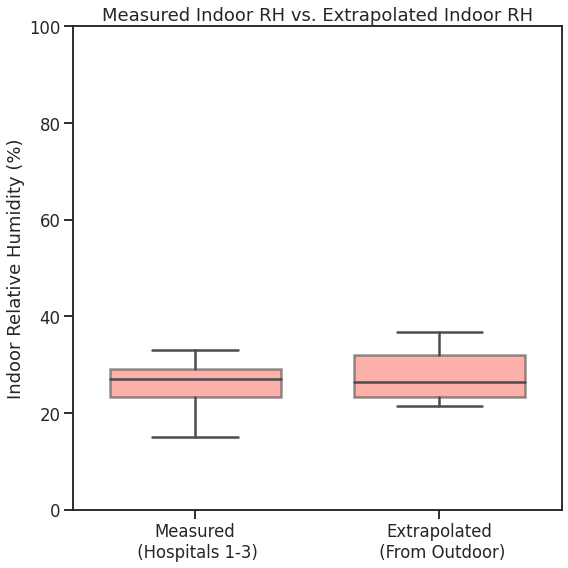

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.boxplot(x='RHName',y='Indoor RH', data=in_vs_out_same, width=width,linewidth=linewidth)

ax.set_ylim(0,100); ax.set_ylabel('Indoor Relative Humidity (%)'); ax.set_xlabel('')
ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax.set_xticklabels(['Measured\n (Hospitals 1-3)','Extrapolated\n (From Outdoor)',])
    
[patch.set_alpha(alpha) for patch in ax.artists]
[ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

fig.tight_layout()

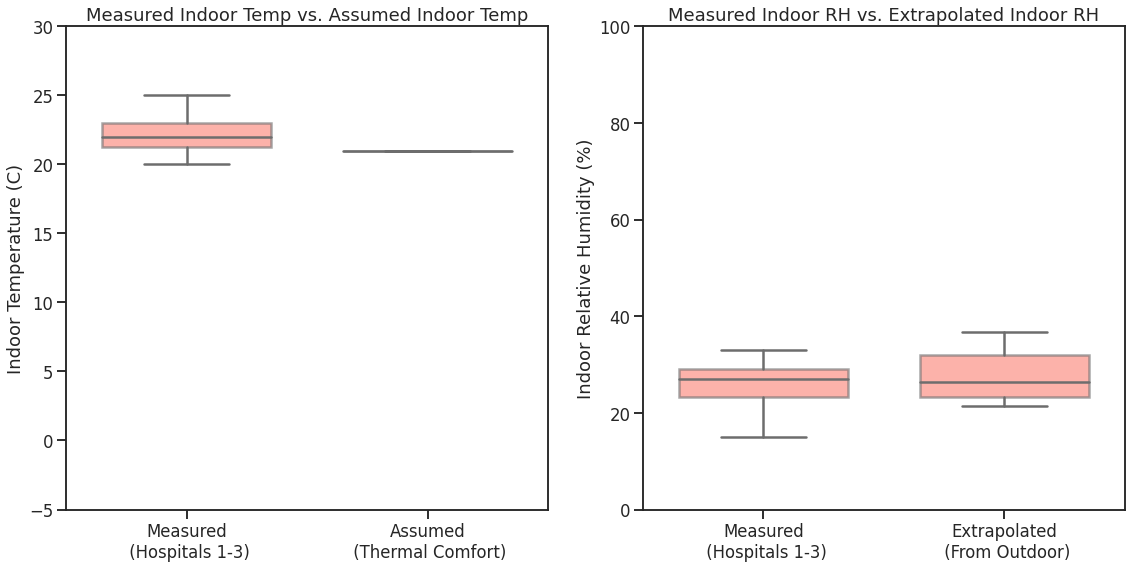

In [ ]:
# If you also want to plot T with the RH comparison 

fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.boxplot(x='TName',y='Indoor T', data=in_vs_out_same, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color)
ax[0].set_ylim(-5,30); ax[0].set_ylabel('Indoor Temperature (C)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor Temp vs. Assumed Indoor Temp')
ax[0].set_xticklabels(['Measured\n (Hospitals 1-3)','Assumed\n (Thermal Comfort)',])

sns.boxplot(x='RHName',y='Indoor RH', data=in_vs_out_same, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax[1].set_xticklabels(['Measured\n (Hospitals 1-3)','Extrapolated\n (From Outdoor)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]

fig.tight_layout()

In [ ]:
# # If you also want to plot T with the RH comparison 

# fig,ax = plt.subplots(1,2,figsize=(16,8))

# alpha = 0.5; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# #sns.stripplot(x='TName',y='Indoor T', data=in_vs_out, ax=ax[0],color=indoor_color,s=s,alpha=alpha)
# sns.boxplot(x='TName',y='Indoor T', data=in_vs_out, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color)
# ax[0].axhline(y=21,linewidth=3,linestyle='--',alpha=1,color='r'); ax[0].annotate('Dashed Line = Assumed Temperature',xy=[1,17],xycoords='data',fontsize=16,ha='center')
# ax[0].set_ylim(-5,30); ax[0].set_ylabel('Indoor Temperature (C)'); ax[0].set_xlabel('')
# ax[0].set_title('Assumed Indoor Temp vs. Measured Indoor Temp')
# ax[0].set_xticklabels(['Hospital #1\n (Measured)','Hospital #2\n (Measured)','Hospital #3\n (Measured)'])

# sns.boxplot(x='RHName',y='Indoor RH', data=in_vs_out, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color)
# ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
# ax[1].set_title('Extrapolated Indoor RH vs. Measured Indoor RH')
# ax[1].set_xticklabels(['Hospital #1\n (Measured)','Hospital #2\n (Measured)','Hospital #3\n (Measured)','Extrapolated',])
    
# [patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]

# fig.tight_layout()

In [ ]:
# Methods to calculate confidence intervals for individual dataset

import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

print(mean_confidence_interval(indoor_longRH['Indoor RH']))


import statsmodels.api as sm

print(sm.stats.DescrStatsW(indoor_longRH['Indoor RH']).tconfint_mean())

(26.166666666666668, 23.528363173762127, 28.80497015957121)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(23.528363173762127, 28.80497015957121)


In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

# Calculate absolute difference in means between measured and extrapolated 
mean_diff = indoor_longRH['Indoor RH'].mean() - outdoor_long['Indoor RH'].mean()

# Calculate confidence interval for difference in means between measured and extrapolated 
compare_mean_diff = sms.CompareMeans(sms.DescrStatsW(indoor_longRH['Indoor RH']), sms.DescrStatsW(outdoor_long['Indoor RH']))

print('\nMean indoor relative humidity measured by sensors:',round(indoor_longRH['Indoor RH'].mean(),2),'+/-',round(indoor_longRH['Indoor RH'].std(),2))

print('\nMean indoor relative humidity estimated by extrapolation workflow:',round(outdoor_long['Indoor RH'].mean(),2),'+/-',round(outdoor_long['Indoor RH'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated:',round(mean_diff,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated:',round(compare_mean_diff.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff.tconfint_diff(usevar='unequal')[1],2))


Mean indoor relative humidity measured by sensors: 26.17 +/- 5.31

Mean indoor relative humidity estimated by extrapolation workflow: 27.84 +/- 5.44

Absolute difference in means between measured and extrapolated: -1.67

95% confidence intervals for difference in means between measured and extrapolated: -5.31 to 1.97


### Sensor Data - Dataset #3

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/48hrs.csv'
# Load the datafile into a pandas dataframe
dset3 = pd.read_csv(filename,header=None).drop(columns=0)

# Rename columns based on info from email 
dset3.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_in_3', 11: 'P_in_3', 12: 'RH_in_3', 
                    13: 'Time_4', 14: 'T_in_4', 15: 'P_in_4', 16: 'RH_in_4', 
                    17: 'Time_5', 18: 'T_in_5', 19: 'P_in_5', 20: 'RH_in_5', 
                    21: 'Time_6', 22: 'T_in_6', 23: 'P_in_6', 24: 'RH_in_6', 
                    25: 'Time_7', 26: 'T_out_1', 27: 'P_out_1', 28: 'RH_out_1', 
                    29: 'Time_8', 30: 'T_out_2', 31: 'P_out_2', 32: 'RH_out_2', }, 
           inplace=True)

from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
dset3.loc[:,'TimeGrowth'] = dset3['Time_1'] - dset3.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
dset3.loc[0,'DateTime'] = datetime(year=2020, month=12, day=5, hour=23, minute=27)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
dset3.loc[:,'DateTime'] = [dset3.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in dset3.loc[:,'TimeGrowth']]

# Check dataframe 
dset3.head()

Time_1  T_in_1  P_in_1  ...  RH_out_2  TimeGrowth                DateTime
0   60361   26.51   99536  ...     45.97           0 2020-12-05 23:27:00.000
1  120497   26.53   99539  ...     59.55       60136 2020-12-05 23:28:00.136
2  180638   26.52   99549  ...     65.93      120277 2020-12-05 23:29:00.277
3  240780   26.50   99537  ...     69.17      180419 2020-12-05 23:30:00.419
4  300921   26.53   99541  ...     71.81      240560 2020-12-05 23:31:00.560

[5 rows x 34 columns]

In [ ]:
# Calculate the outdoor absolute humidity. Based on the measurements provided by the 2 outdoor sensors 
dset3.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(dset3['T_out_1'], dset3['RH_out_1'])]

dset3.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(dset3['T_out_2'], dset3['RH_out_2'])]

Thermal_Comfort_Temp = 21 # degrees C

# Extrapolate the indoor relative humidity. Assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
dset3.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(dset3['T_out_1'], dset3['out_AH_1'])]

dset3.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(dset3['T_out_2'], dset3['out_AH_2'])]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison.csv'

# Read in the csv and parse the date and time  
cam3 = pd.read_csv(filename,parse_dates=[[0,1]]).drop(columns=['Weather','Wind','Barometer']).rename(columns={'Date_Time':'DateTime'})

# # Read in the csv 
# cam3 = pd.read_excel('Cambridge_Weather_For_Comparison.xlsx').drop(columns=['Weather','Wind','Barometer'])

# from datetime import datetime, date, timedelta 

# # Make a datetime column that combines the date column and time column 
# cam3.loc[:,'DateTime'] = cam3.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam3.loc[:,'TimeDiff'] = cam3['DateTime'] - cam3.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam3.loc[:,'Time_ms'] = cam3['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam3.loc[:,'Humidity'] = cam3['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam3.loc[:,'Humidity'] = cam3['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam3.loc[:,'Temp_C'] = cam3['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Check the df
cam3.head()

DateTime Temp_F  Humidity        TimeDiff     Time_ms    Temp_C
0 2020-12-05 23:54:00    35       85.0 0 days 00:00:00         0.0  1.666667
1 2020-12-06 00:54:00    34       82.0 0 days 01:00:00   3600000.0  1.111111
2 2020-12-06 01:54:00    34       79.0 0 days 02:00:00   7200000.0  1.111111
3 2020-12-06 02:54:00    34       73.0 0 days 03:00:00  10800000.0  1.111111
4 2020-12-06 03:42:00    33       72.0 0 days 03:48:00  13680000.0  0.555556

In [ ]:
# Calculate the outdoor absolute humidity. Based on the outdoor weather
cam3.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(cam3['Temp_C'], cam3['Humidity'])]

Thermal_Comfort_Temp = 21 # degrees C

# Extrapolate the indoor relative humidity. Assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
cam3.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(cam3['Temp_C'], cam3['out_AH_1'])]

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(18,6))

# alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.lineplot(x='Time_7',y='T_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='Time_8',y='T_out_2',data=dset3,label='Outdoor Sensor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='Time_ms',y='Temp_C',data=cam3,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# sns.lineplot(x='Time_7',y='RH_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='Time_8',y='RH_out_1',data=dset3,label='Outdoor Sensor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='Time_ms',y='Humidity',data=cam3,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
# ax[0].set_title('Comparing Outdoor Temperature Timeseries')

# ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
# ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries')

# ax[0].set_ylim(-7.5,30); ax[1].set_ylim(0,100)

# ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

# fig.tight_layout()

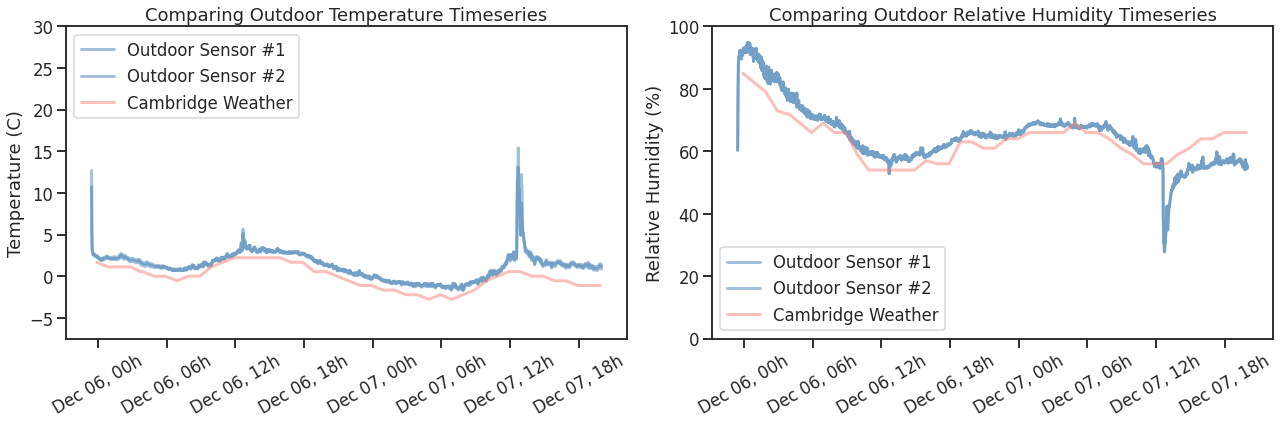

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=dset3,label='Outdoor Sensor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam3,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_1',data=dset3,label='Outdoor Sensor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam3,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries')

ax[0].set_ylim(-7.5,30); ax[1].set_ylim(0,100)

ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes];
[ax.tick_params(axis='x', rotation=30) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

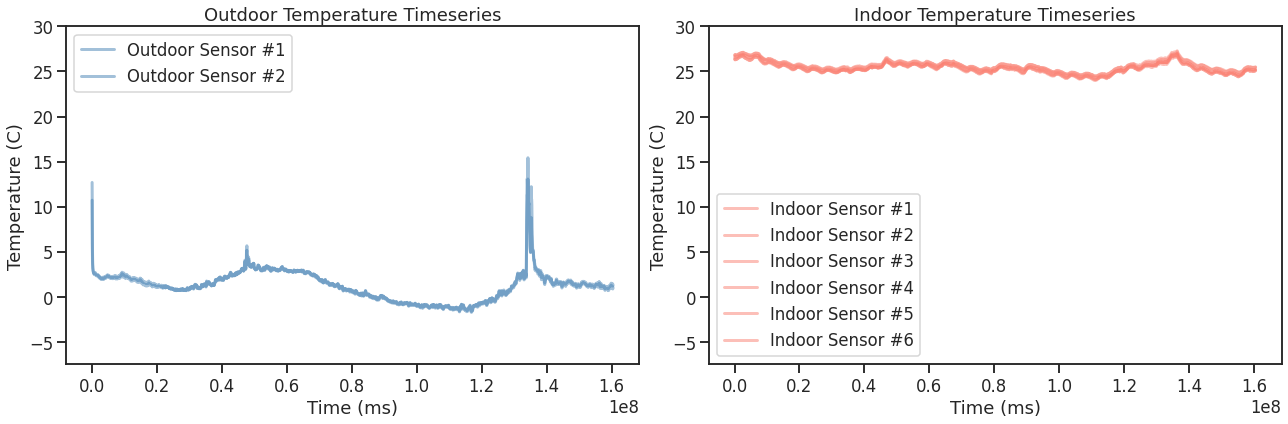

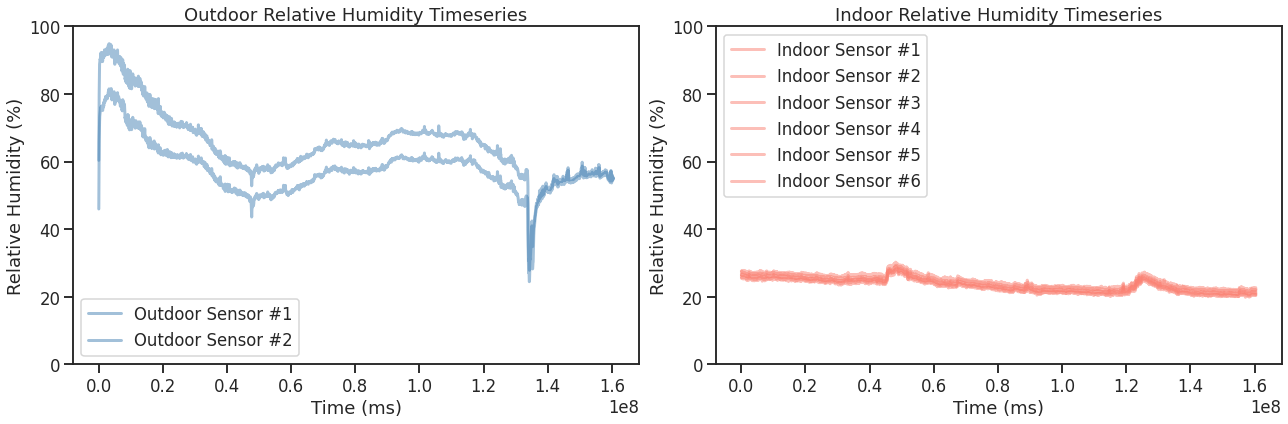

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='Time_7',y='T_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='Time_8',y='T_out_2',data=dset3,label='Outdoor Sensor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)

sns.lineplot(x='Time_1',y='T_in_1',data=dset3,label='Indoor Sensor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_2',y='T_in_2',data=dset3,label='Indoor Sensor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_3',y='T_in_3',data=dset3,label='Indoor Sensor #3',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_4',y='T_in_4',data=dset3,label='Indoor Sensor #4',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_5',y='T_in_5',data=dset3,label='Indoor Sensor #5',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_6',y='T_in_6',data=dset3,label='Indoor Sensor #6',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Temperature Timeseries')
ax[1].set_ylabel('Temperature (C)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Temperature Timeseries')

[ax.set_ylim(-7.5,30) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

fig.tight_layout()



fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='Time_7',y='RH_out_1',data=dset3,label='Outdoor Sensor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='Time_8',y='RH_out_2',data=dset3,label='Outdoor Sensor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)

sns.lineplot(x='Time_1',y='RH_in_1',data=dset3,label='Indoor Sensor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_2',y='RH_in_2',data=dset3,label='Indoor Sensor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_3',y='RH_in_3',data=dset3,label='Indoor Sensor #3',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_4',y='RH_in_4',data=dset3,label='Indoor Sensor #4',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_5',y='RH_in_5',data=dset3,label='Indoor Sensor #5',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='Time_6',y='RH_in_6',data=dset3,label='Indoor Sensor #6',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Relative Humidity Timeseries')
ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Relative Humidity Timeseries')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='lower left'); ax[1].legend(loc='upper left')

fig.tight_layout()

In [ ]:
# Define the names of the inner and outer columns that you want to stack 
dset3_indoorT_names = ['T_in_1','T_in_2','T_in_3','T_in_4','T_in_5','T_in_6']; dset3_indoorRH_names = ['RH_in_1','RH_in_2','RH_in_3','RH_in_4','RH_in_5','RH_in_6']
dset3_outdoorT_names = ['T_out_1','T_out_2']; dset3_outdoorRH_names = ['RH_out_1','RH_out_2']

# Combine and reformat the temperature and relative humidity columns for the indoor sensors
dset3_indoorT = dset3[dset3_indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); dset3_indoorT.loc[:,'TName'] = 'T_in'
dset3_indoorRH = dset3[dset3_indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); dset3_indoorRH.loc[:,'RHName'] = 'RH_in'

# Combine and reformat the temperature and relative humidity columns for the outdoor sensors
dset3_outdoorT = dset3[dset3_outdoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Outdoor T'}); dset3_outdoorT.loc[:,'TName'] = 'T_out'
dset3_outdoorRH = dset3[dset3_outdoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Outdoor RH'}); dset3_outdoorRH.loc[:,'RHName'] = 'RH_out'

# Concatenate the dataframes
in_vs_out = pd.concat([dset3_indoorT,dset3_indoorRH,dset3_outdoorT,dset3_outdoorRH])#,axis=1)
#in_vs_out

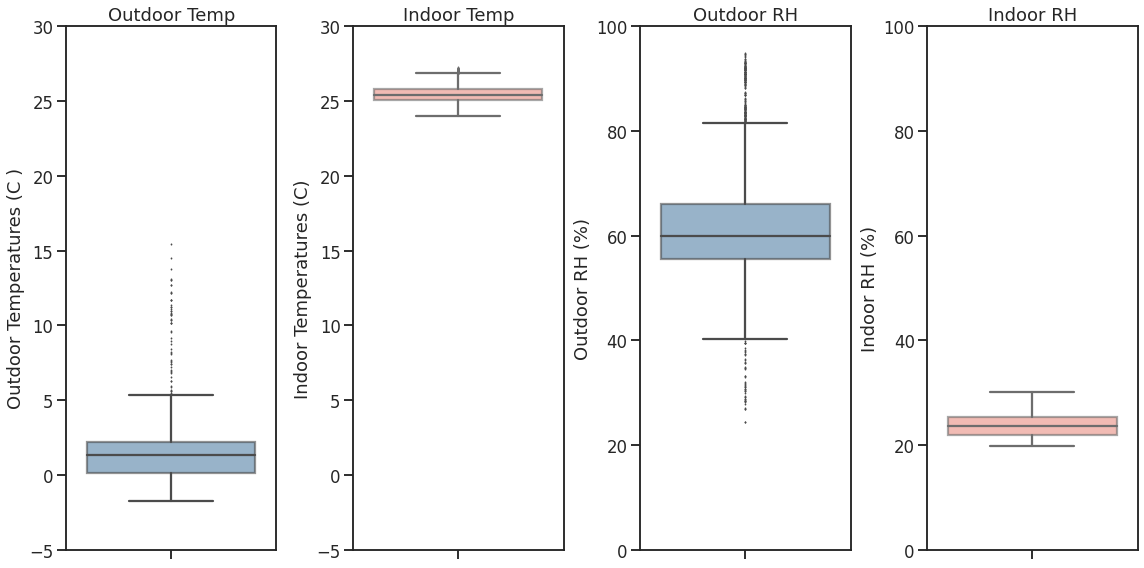

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-5,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,100); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH')

fig.tight_layout()

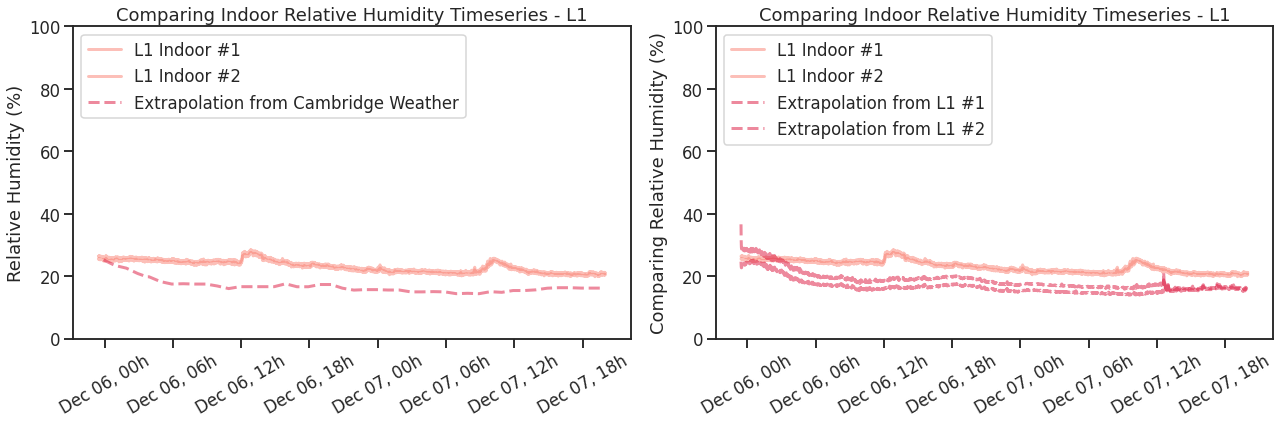

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=dset3,label='L1 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=dset3,label='L1 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam3,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=dset3,label='L1 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=dset3,label='L1 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=dset3,label='Extrapolation from L1 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=dset3,label='Extrapolation from L1 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L1')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L1')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes];
[ax.tick_params(axis='x', rotation=30) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

In [ ]:
# Define the names of the inner and outer columns that you want to stack 
dset3_indoorRH_names = ['RH_in_1','RH_in_2','RH_in_3','RH_in_4','RH_in_5','RH_in_6']; dset3_indoorRH_ext_names = ['in_RH_CALC_1','in_RH_CALC_2']; cam3_indoorRH_names = ['in_RH_CALC_1']

# Combine the indoor humidity sensors (duplicate column so you can avoid plotting all 3 on the same graph)
dset3_indoorRH = dset3[dset3_indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); dset3_indoorRH.loc[:,'RHName'] = 'RH_in'
dset3_indoorRH2 = dset3[dset3_indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); dset3_indoorRH2.loc[:,'RHName2'] = 'RH_in' # Duplicate column and rename header and identifier

# Combine the extrapolations based on outdoor sensors and combine the extrapolations based on outdoor cambridge weather 
dset3_indoorRH_ext = dset3[dset3_indoorRH_ext_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); dset3_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
cam3_indoorRH_ext = cam3[cam3_indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); cam3_indoorRH_ext.loc[:,'RHName2'] = 'RH_ext_cam'

# Concatenate the dataframes
in_vs_in = pd.concat([dset3_indoorRH,dset3_indoorRH2,dset3_indoorRH_ext,cam3_indoorRH_ext])#,axis=1)
#in_vs_in

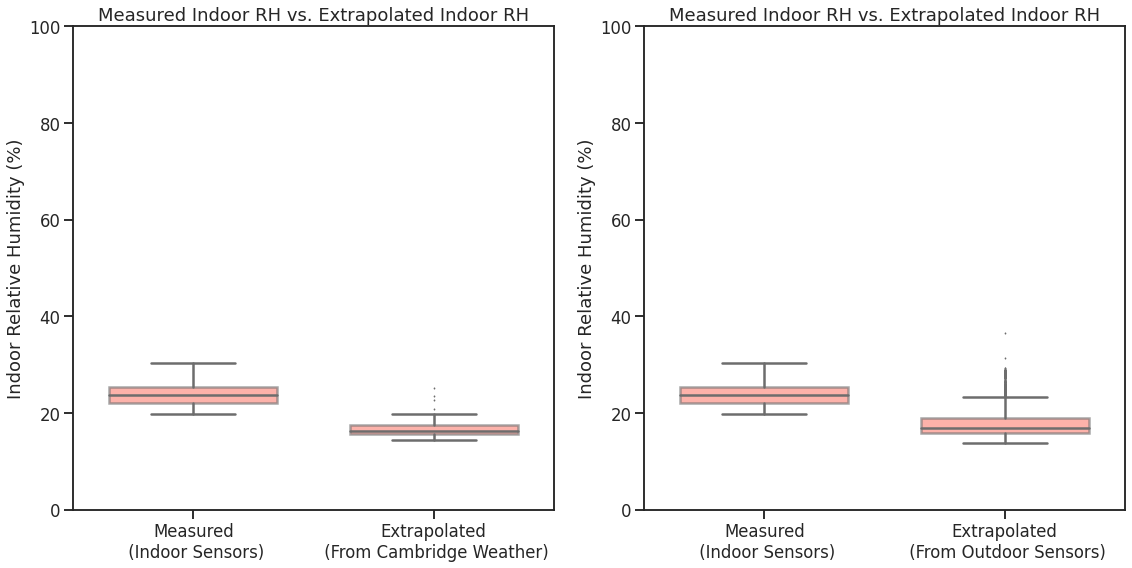

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(x='RHName2',y='Indoor RH2', data=in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]

fig.tight_layout()

In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

# Calculate absolute difference in means between measured and extrapolated 
mean_diff_cam = dset3_indoorRH2['Indoor RH2'].mean() - cam3_indoorRH_ext['Indoor RH2'].mean()
mean_diff_sensor = dset3_indoorRH['Indoor RH'].mean() - dset3_indoorRH_ext['Indoor RH'].mean()

# Calculate confidence interval for difference in means between measured and extrapolated 
compare_mean_diff_cam = sms.CompareMeans(sms.DescrStatsW(dset3_indoorRH2['Indoor RH2']), sms.DescrStatsW(cam3_indoorRH_ext['Indoor RH2']))
compare_mean_diff_sensor = sms.CompareMeans(sms.DescrStatsW(dset3_indoorRH['Indoor RH']), sms.DescrStatsW(dset3_indoorRH_ext['Indoor RH']))


print('\nMean indoor relative humidity measured by sensors:',round(dset3_indoorRH['Indoor RH'].mean(),2),'+/-',round(dset3_indoorRH['Indoor RH'].std(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from Cambridge weather:',round(cam3_indoorRH_ext['Indoor RH2'].mean(),2),'+/-',round(cam3_indoorRH_ext['Indoor RH2'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from Cambridge weather:',round(mean_diff_cam,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather:',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[1],2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from outdoor sensors:',round(dset3_indoorRH_ext['Indoor RH'].mean(),2),'+/-',round(dset3_indoorRH_ext['Indoor RH'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from outdoor sensors:',round(mean_diff_sensor,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from outdoor sensors:',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[1],2))


Mean indoor relative humidity measured by sensors: 23.72 +/- 2.04

Mean indoor relative humidity estimated by extrapolation workflow from Cambridge weather: 16.86 +/- 2.29

Absolute difference in means between measured and extrapolated from Cambridge weather: 6.86

95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather: 6.19 to 7.53

Mean indoor relative humidity estimated by extrapolation workflow from outdoor sensors: 17.67 +/- 2.91

Absolute difference in means between measured and extrapolated from outdoor sensors: 6.05

95% confidence intervals for difference in means between measured and extrapolated from outdoor sensors: 5.96 to 6.13


### Sensor Data - L1 and L2 Longterm

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/L1-12112020-830pm_v2.dat'

l1=np.loadtxt(filename)

# # Load the datafile into a numpy array
# l1 = np.loadtxt('L1-12112020-830pm_v2.dat')

# Convert the array into a dataframe 
l1 = pd.DataFrame(l1).drop(columns=0)

# Rename columns based on dataset info document  
l1.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_out_1', 11: 'P_out_1', 12: 'RH_out_1', 
                    13: 'Time_4', 14: 'T_out_2', 15: 'P_out_2', 16: 'RH_out_2', }, 
           inplace=True)

from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
l1.loc[:,'TimeGrowth'] = l1['Time_1'] - l1.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
l1.loc[0,'DateTime'] = datetime(year=2020, month=12, day=11, hour=20, minute=30)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
l1.loc[:,'DateTime'] = [l1.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in l1.loc[:,'TimeGrowth']]

# Check df
l1.head()

Time_1  T_in_1    P_in_1  ...  RH_out_2  TimeGrowth                DateTime
0     121.0   19.08  101936.0  ...     82.34         0.0 2020-12-11 20:30:00.000
1   60151.0   19.27  101933.0  ...     82.48     60030.0 2020-12-11 20:31:00.030
2  120190.0   19.40  101926.0  ...     82.53    120069.0 2020-12-11 20:32:00.069
3  180233.0   19.50  101934.0  ...     83.41    180112.0 2020-12-11 20:33:00.112
4  240276.0   19.54  101947.0  ...     83.24    240155.0 2020-12-11 20:34:00.155

[5 rows x 18 columns]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/L2-12112020-950pm_v2.dat'

l2=np.loadtxt(filename)

# # Load the datafile into a numpy array
# l2 = np.loadtxt('L2-12112020-950pm_v2.dat')

# Convert the array into a dataframe 
l2 = pd.DataFrame(l2).drop(columns=0)

# Rename columns based on dataset info document  
l2.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_out_1', 11: 'P_out_1', 12: 'RH_out_1', 
                    13: 'Time_4', 14: 'T_out_2', 15: 'P_out_2', 16: 'RH_out_2', }, 
           inplace=True)

from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
l2.loc[:,'TimeGrowth'] = l2['Time_1'] - l2.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
l2.loc[0,'DateTime'] = datetime(year=2020, month=12, day=11, hour=21, minute=50)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
l2.loc[:,'DateTime'] = [l2.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in l2.loc[:,'TimeGrowth']]

# Drop the last few rows because one of the sensors malfunctioned
l2 = l2.iloc[:7377,:]

# Check df
l2.head()

Time_1  T_in_1    P_in_1  ...  RH_out_2  TimeGrowth                DateTime
0     121.0   25.43  101838.0  ...     61.12         0.0 2020-12-11 21:50:00.000
1   60152.0   25.49  101842.0  ...     62.77     60031.0 2020-12-11 21:51:00.031
2  120190.0   25.50  101841.0  ...     64.03    120069.0 2020-12-11 21:52:00.069
3  180232.0   25.49  101843.0  ...     64.93    180111.0 2020-12-11 21:53:00.111
4  240273.0   25.49  101845.0  ...     65.85    240152.0 2020-12-11 21:54:00.152

[5 rows x 18 columns]

In [ ]:
# Calculate the outdoor absolute humidity. Based on the measurements provided by the 2 outdoor sensors 
l1.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l1['T_out_1'], l1['RH_out_1'])]

l1.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l1['T_out_2'], l1['RH_out_2'])]

l2.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l2['T_out_1'], l2['RH_out_1'])]

l2.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l2['T_out_2'], l2['RH_out_2'])]

Thermal_Comfort_Temp = 21 # degrees C

# Extrapolate the indoor relative humidity. Assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
l1.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l1['T_out_1'], l1['out_AH_1'])]

l1.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l1['T_out_2'], l1['out_AH_2'])]

l2.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l2['T_out_1'], l2['out_AH_1'])]

l2.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l2['T_out_2'], l2['out_AH_2'])]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison_TwoBuildings_v2.csv'

# Read in the csv and parse the date and time  
cam = pd.read_csv(filename,parse_dates=[[0,1]],usecols=[0,1,2,3,4,5,6],nrows=150).drop(columns=['Weather','Wind','Barometer',]).rename(columns={'Date_Time':'DateTime'})

# # Read in the excel 
# cam = pd.read_excel('Cambridge_Weather_For_Comparison_TwoBuildings_v2.xlsx').drop(columns=['Weather','Wind','Barometer'])

# from datetime import datetime, date, timedelta 

# # Make a datetime column that combines the date column and time column 
# cam.loc[:,'DateTime'] = cam.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam.loc[:,'TimeDiff'] = cam['DateTime'] - cam.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam.loc[:,'Time_ms'] = cam['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam3.loc[:,'Humidity'] = cam3['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam.loc[:,'Humidity'] = cam['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam.loc[:,'Temp_C'] = cam['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Check the df
cam.head()

DateTime Temp_F  Humidity        TimeDiff     Time_ms    Temp_C
0 2020-12-11 19:54:00    46       77.0 0 days 00:00:00         0.0  7.777778
1 2020-12-11 20:54:00    46       79.0 0 days 01:00:00   3600000.0  7.777778
2 2020-12-11 21:54:00    44       85.0 0 days 02:00:00   7200000.0  6.666667
3 2020-12-11 22:54:00    43       89.0 0 days 03:00:00  10800000.0  6.111111
4 2020-12-11 23:54:00    42       89.0 0 days 04:00:00  14400000.0  5.555556

In [ ]:
# Calculate the outdoor absolute humidity 
# Based on the measurements provided by the 2 outdoor sensors 
cam.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(cam['Temp_C'], cam['Humidity'])]

Thermal_Comfort_Temp = 21 # degrees C

# Extrapolate the indoor relative humidity 
# Assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
cam.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(cam['Temp_C'], cam['out_AH_1'])]

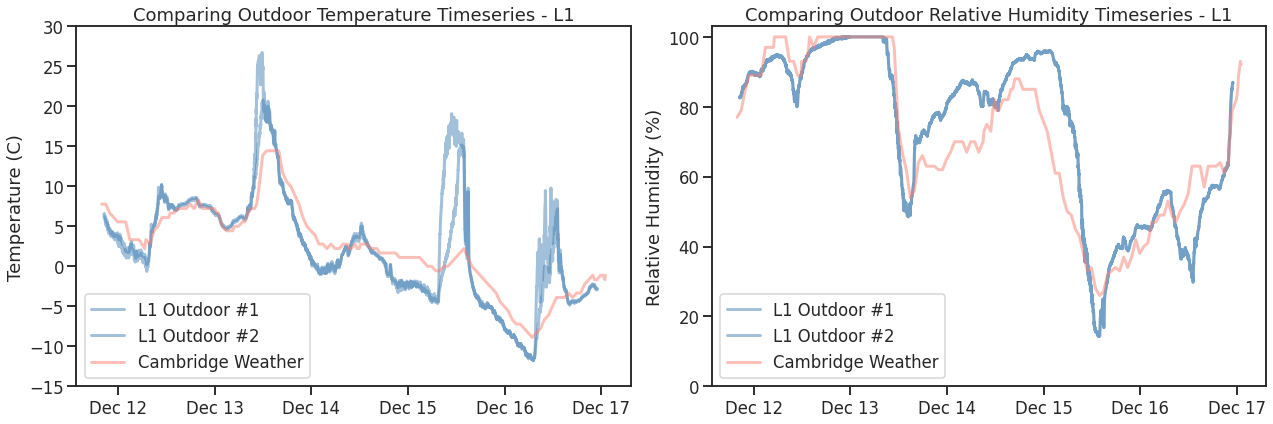

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l1,label='L1 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l1,label='L1 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=l1,label='L1 Outdoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_1',data=l1,label='L1 Outdoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries - L1')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries - L1')

ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
#[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout()

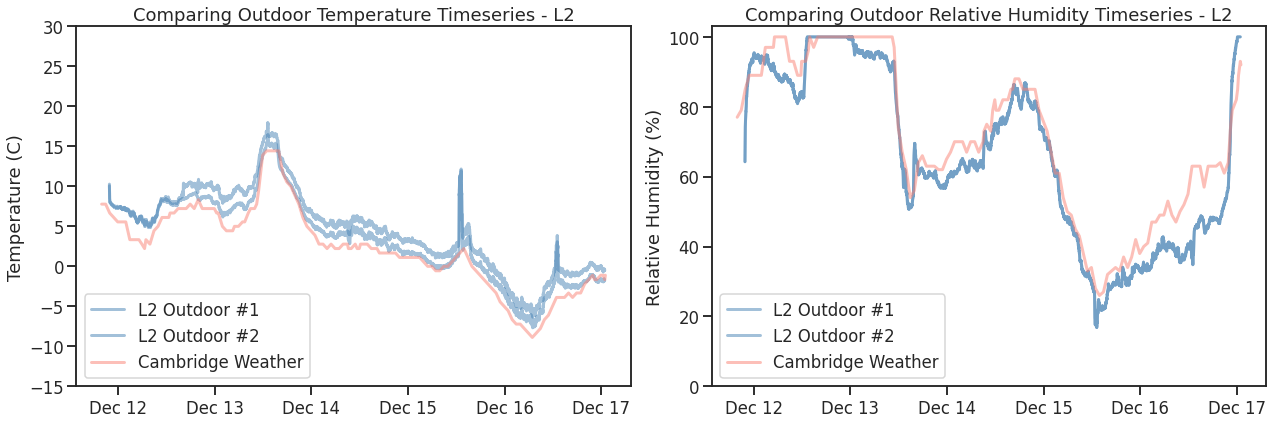

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l2,label='L2 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l2,label='L2 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=l2,label='L2 Outdoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_1',data=l2,label='L2 Outdoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries - L2')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries - L2')

ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
#[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout()

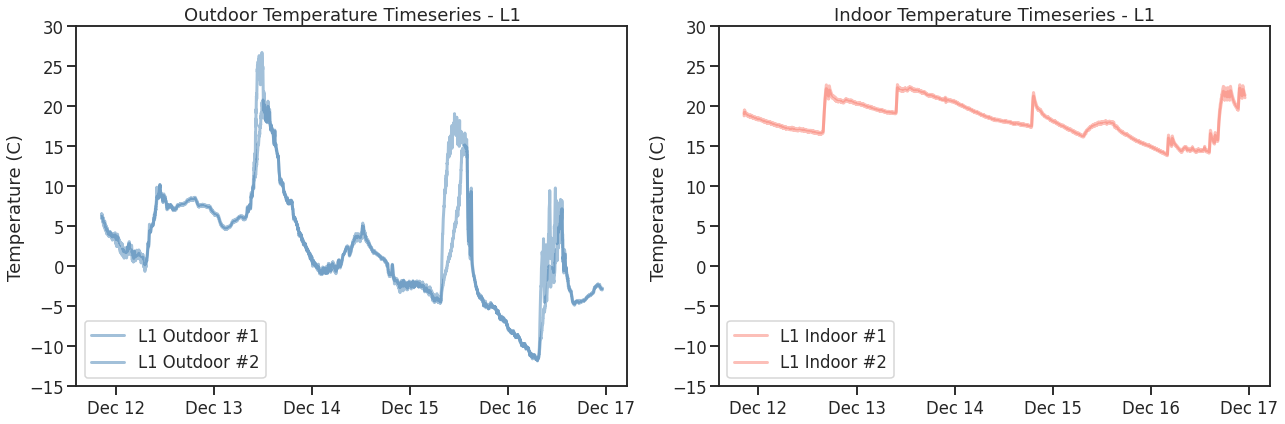

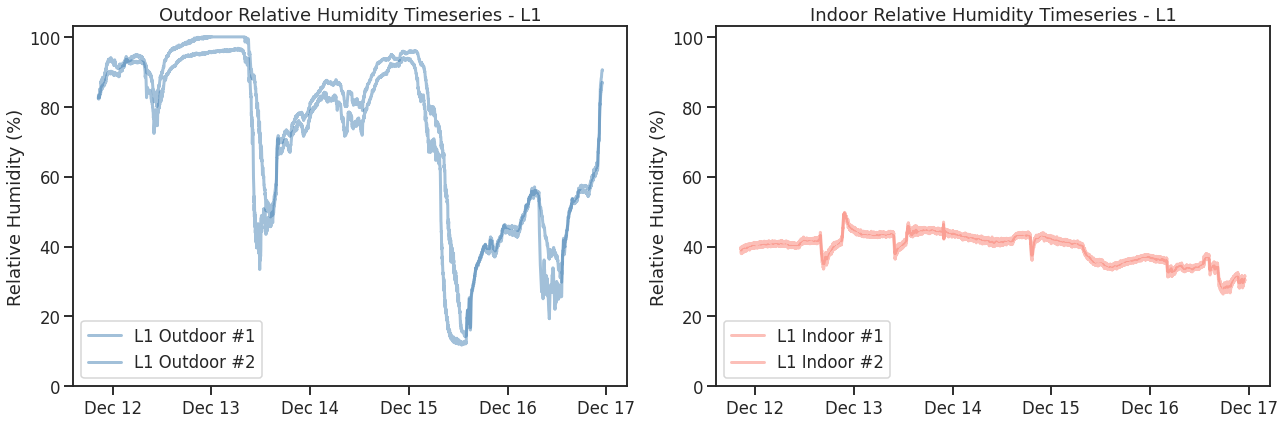

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l1,label='L1 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l1,label='L1 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_in_1',data=l1,label='L1 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_in_2',data=l1,label='L1 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Temperature Timeseries - L1')
ax[1].set_ylabel('Temperature (C)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Temperature Timeseries - L1')
[ax.set_ylim(-15,30) for ax in plt.gcf().axes]
ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()


fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='RH_out_1',data=l1,label='L1 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_2',data=l1,label='L1 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_1',data=l1,label='L1 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l1,label='L1 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Relative Humidity Timeseries - L1')
ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Relative Humidity Timeseries - L1')

[ax.set_ylim(0,103) for ax in plt.gcf().axes]
ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

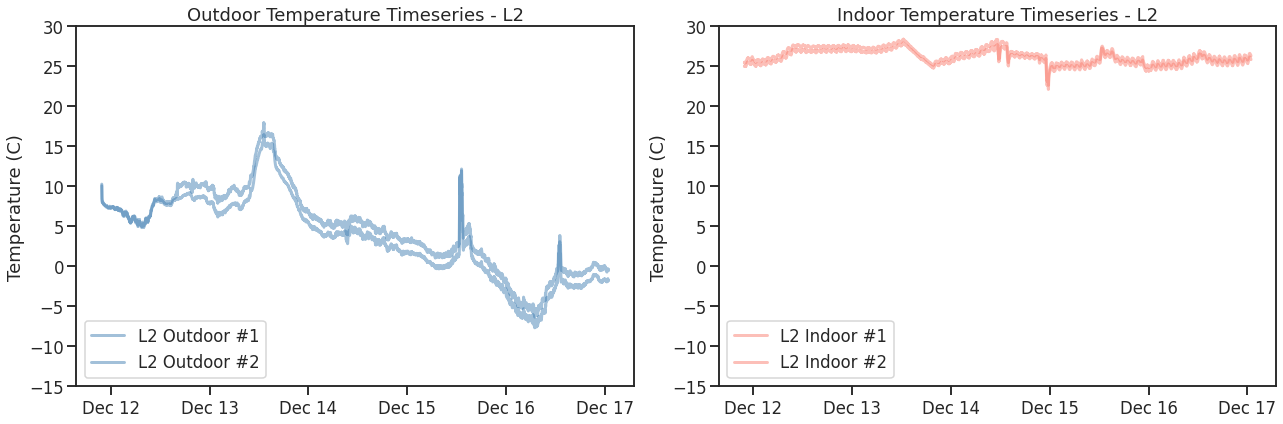

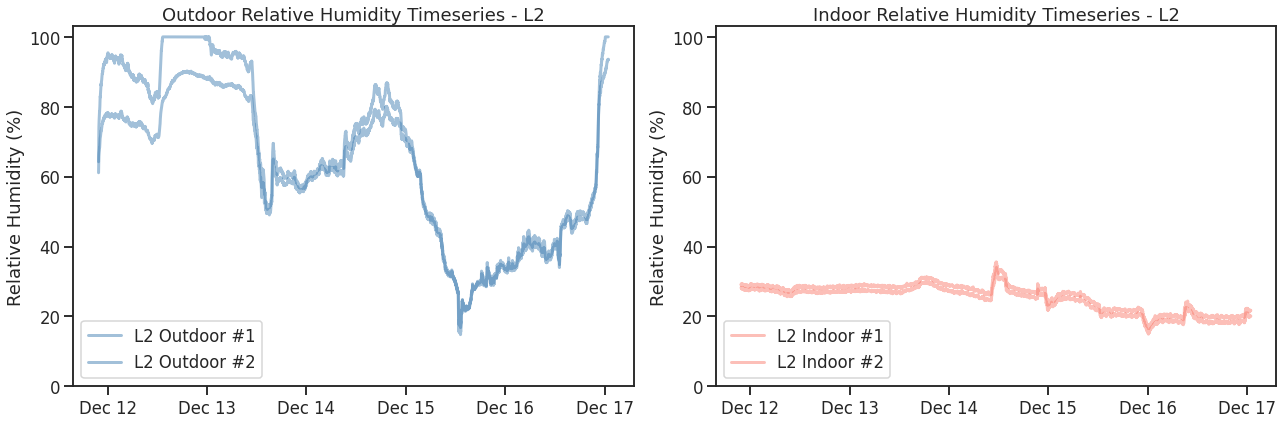

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l2,label='L2 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l2,label='L2 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_in_1',data=l2,label='L2 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_in_2',data=l2,label='L2 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Temperature Timeseries - L2')
ax[1].set_ylabel('Temperature (C)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Temperature Timeseries - L2')
[ax.set_ylim(-15,30) for ax in plt.gcf().axes]
ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()


fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='RH_out_1',data=l2,label='L2 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_2',data=l2,label='L2 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_1',data=l2,label='L2 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l2,label='L2 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Outdoor Relative Humidity Timeseries - L2')
ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Indoor Relative Humidity Timeseries - L2')

[ax.set_ylim(0,103) for ax in plt.gcf().axes]
ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

In [ ]:
# Define the names of the inner and outer columns that you want to stack 
indoorT_names = ['T_in_1','T_in_2']; indoorRH_names = ['RH_in_1','RH_in_2']
outdoorT_names = ['T_out_1','T_out_2']; outdoorRH_names = ['RH_out_1','RH_out_2']

# Combine and reformat the temperature and relative humidity columns for the indoor sensors
l1_indoorT = l1[indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); l1_indoorT.loc[:,'TName'] = 'T_in'
l1_indoorRH = l1[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l1_indoorRH.loc[:,'RHName'] = 'RH_in'
l2_indoorT = l2[indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); l2_indoorT.loc[:,'TName'] = 'T_in'
l2_indoorRH = l2[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l2_indoorRH.loc[:,'RHName'] = 'RH_in'

# Combine and reformat the temperature and relative humidity columns for the outdoor sensors
l1_outdoorT = l1[outdoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Outdoor T'}); l1_outdoorT.loc[:,'TName'] = 'T_out'
l1_outdoorRH = l1[outdoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Outdoor RH'}); l1_outdoorRH.loc[:,'RHName'] = 'RH_out'
l2_outdoorT = l2[outdoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Outdoor T'}); l2_outdoorT.loc[:,'TName'] = 'T_out'
l2_outdoorRH = l2[outdoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Outdoor RH'}); l2_outdoorRH.loc[:,'RHName'] = 'RH_out'

# Concatenate the dataframes
l1_in_vs_out = pd.concat([l1_indoorT,l1_indoorRH,l1_outdoorT,l1_outdoorRH])#,axis=1)
l2_in_vs_out = pd.concat([l2_indoorT,l2_indoorRH,l2_outdoorT,l2_outdoorRH])#,axis=1)

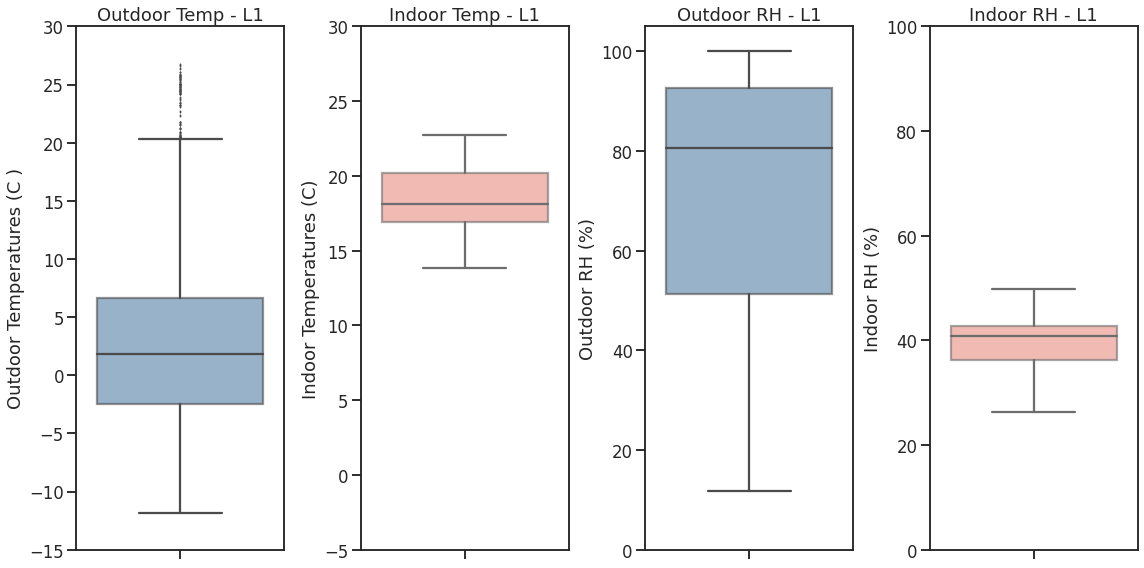

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=l1_in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=l1_in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=l1_in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=l1_in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-15,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,105); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp - L1'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp - L1')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH - L1')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH - L1')

fig.tight_layout()

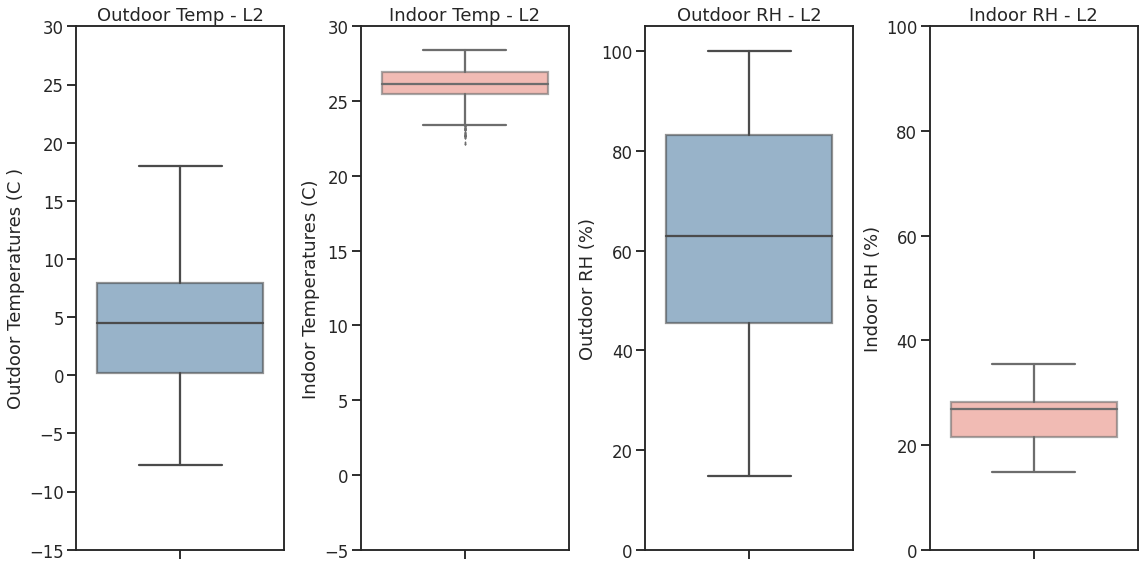

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=l2_in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=l2_in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=l2_in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=l2_in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-15,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,105); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp - L2'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp - L2')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH - L2')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH - L2')

fig.tight_layout()

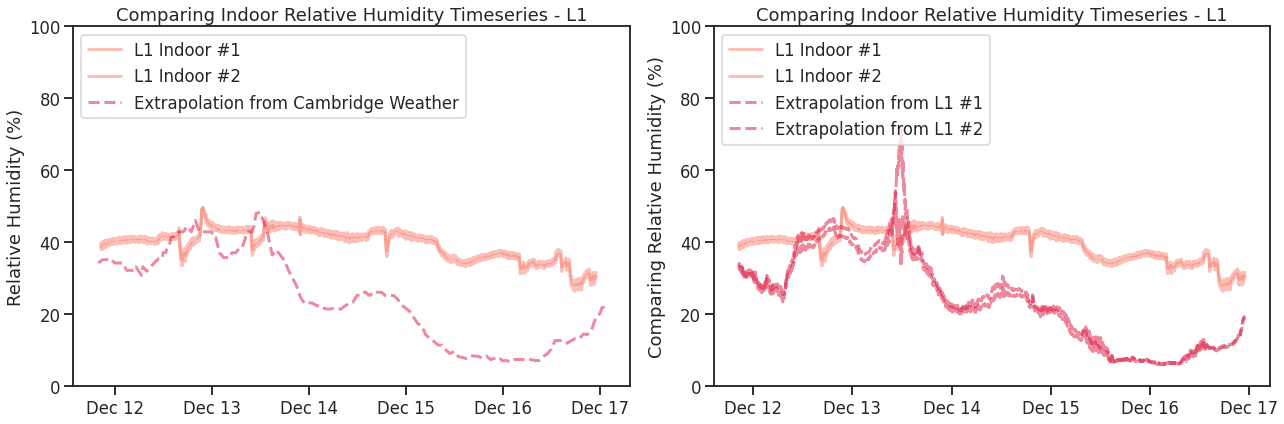

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=l1,label='L1 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l1,label='L1 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=l1,label='L1 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l1,label='L1 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=l1,label='Extrapolation from L1 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=l1,label='Extrapolation from L1 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L1')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L1')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

In [ ]:
l1[['RH_out_1','RH_out_2']].stack().mean()

71.61054859787636

In [ ]:
cam['Humidity'].mean()

74.38666666666667

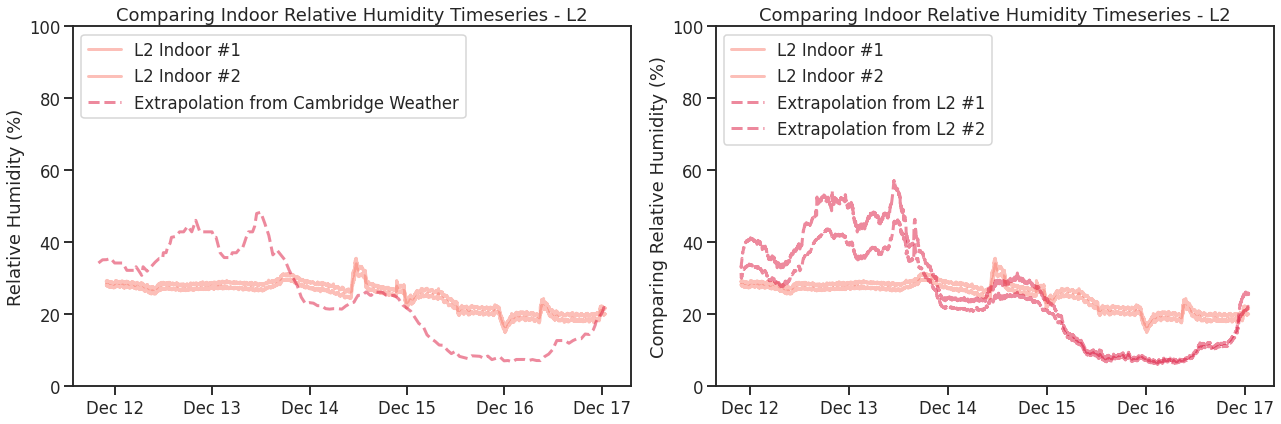

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=l2,label='L2 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l2,label='L2 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=l2,label='L2 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l2,label='L2 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=l2,label='Extrapolation from L2 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=l2,label='Extrapolation from L2 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L2')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L2')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

In [ ]:
# Define the names of the columns that you want to stack 
indoorRH_names = ['RH_in_1','RH_in_2']; indoorRH_ext_names = ['in_RH_CALC_1','in_RH_CALC_2']

# Combine the indoor humidity sensors (duplicate column so you can avoid plotting all 3 on the same graph)
l1_indoorRH = l1[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l1_indoorRH.loc[:,'RHName'] = 'RH_in'
l1_indoorRH2 = l1[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); l1_indoorRH2.loc[:,'RHName2'] = 'RH_in'
l2_indoorRH = l2[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l2_indoorRH.loc[:,'RHName'] = 'RH_in'
l2_indoorRH2 = l2[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); l2_indoorRH2.loc[:,'RHName2'] = 'RH_in'

# Combine the extrapolations based on outdoor sensors and combine the extrapolations based on outdoor cambridge weather 
l1_indoorRH_ext = l1[indoorRH_ext_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l1_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
l1_indoorRH_ext_cam = cam[indoorRH_ext_names[0]].reset_index().rename(columns={'index': 'RHName2','in_RH_CALC_1': 'Indoor RH2'}); l1_indoorRH_ext_cam.loc[:,'RHName2'] = 'RH_ext_cam'
l2_indoorRH_ext = l2[indoorRH_ext_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l2_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
l2_indoorRH_ext_cam = cam[indoorRH_ext_names[0]].reset_index().rename(columns={'index': 'RHName2','in_RH_CALC_1': 'Indoor RH2'}); l2_indoorRH_ext_cam.loc[:,'RHName2'] = 'RH_ext_cam'

# Concatenate the dataframes
l1_in_vs_in = pd.concat([l1_indoorRH,l1_indoorRH2,l1_indoorRH_ext,l1_indoorRH_ext_cam])#,axis=1)
l2_in_vs_in = pd.concat([l2_indoorRH,l2_indoorRH2,l2_indoorRH_ext,l2_indoorRH_ext_cam])#,axis=1)

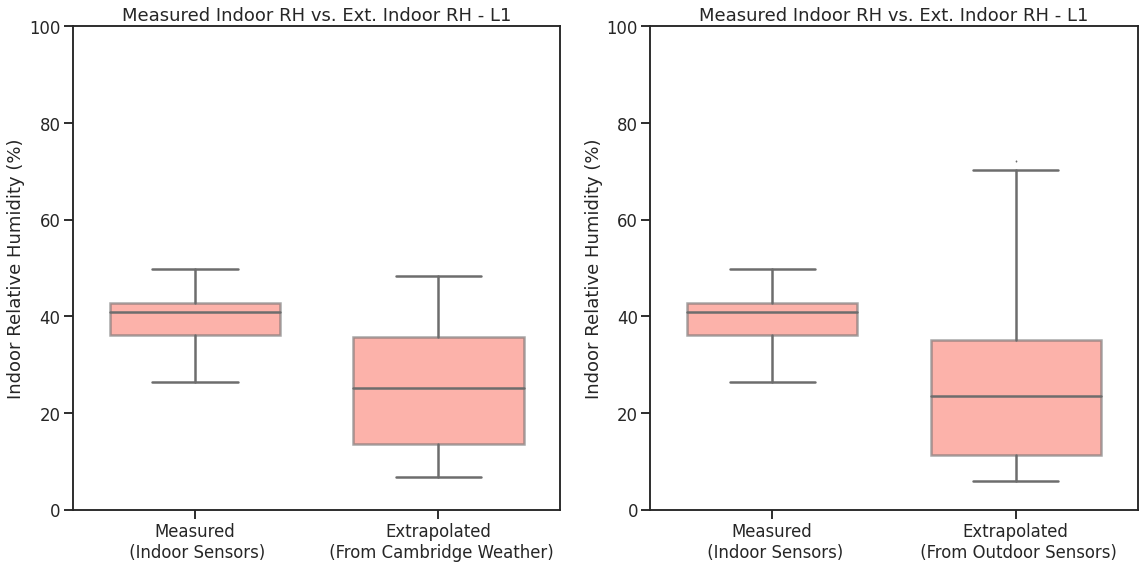

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1; indoor_color2 = 'darkred'

sns.boxplot(x='RHName2',y='Indoor RH2', data=l1_in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Ext. Indoor RH - L1')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=l1_in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Ext. Indoor RH - L1')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]
#[ax[j].artists[i].set_facecolor(indoor_color2) for i in range(1,2) for j in range(0,2)]


fig.tight_layout()

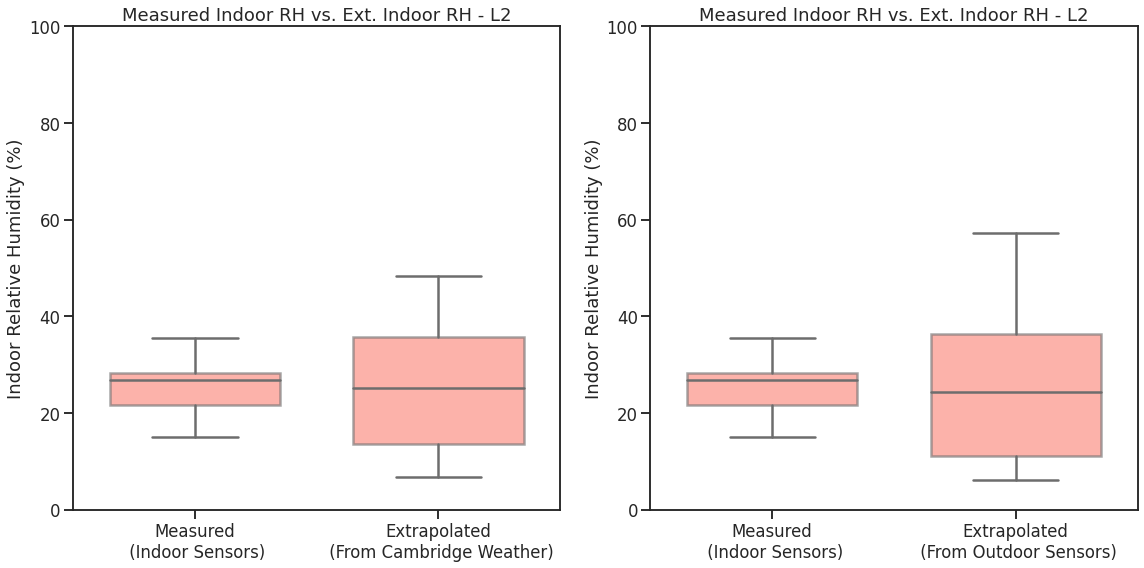

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(x='RHName2',y='Indoor RH2', data=l2_in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Ext. Indoor RH - L2')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=l2_in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Ext. Indoor RH - L2')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]

fig.tight_layout()

In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

# Calculate absolute difference in means between measured and extrapolated 
mean_diff_cam = l1_indoorRH2['Indoor RH2'].mean() - l1_indoorRH_ext_cam['Indoor RH2'].mean()
mean_diff_sensor = l1_indoorRH['Indoor RH'].mean() - l1_indoorRH_ext['Indoor RH'].mean()

# Calculate confidence interval for difference in means between measured and extrapolated 
compare_mean_diff_cam = sms.CompareMeans(sms.DescrStatsW(l1_indoorRH2['Indoor RH2']), sms.DescrStatsW(l1_indoorRH_ext_cam['Indoor RH2']))
compare_mean_diff_sensor = sms.CompareMeans(sms.DescrStatsW(l1_indoorRH['Indoor RH']), sms.DescrStatsW(l1_indoorRH_ext['Indoor RH']))


print('Mean indoor relative humidity measured by L1 sensors:',round(l1_indoorRH['Indoor RH'].mean(),2),'+/-',round(l1_indoorRH['Indoor RH'].std(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from Cambridge weather:',round(l1_indoorRH_ext_cam['Indoor RH2'].mean(),2),'+/-',round(l1_indoorRH_ext_cam['Indoor RH2'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from Cambridge weather:',round(mean_diff_cam,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather:',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[1],2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from L1 outdoor sensors:',round(l1_indoorRH_ext['Indoor RH'].mean(),2),'+/-',round(l1_indoorRH_ext['Indoor RH'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from L1 outdoor sensors:',round(mean_diff_sensor,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from L1 outdoor sensors:',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[1],2))

Mean indoor relative humidity measured by L1 sensors: 39.56 +/- 4.25

Mean indoor relative humidity estimated by extrapolation workflow from Cambridge weather: 25.55 +/- 12.22

Absolute difference in means between measured and extrapolated from Cambridge weather: 14.01

95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather: 12.04 to 15.98

Mean indoor relative humidity estimated by extrapolation workflow from L1 outdoor sensors: 24.05 +/- 12.8

Absolute difference in means between measured and extrapolated from L1 outdoor sensors: 15.51

95% confidence intervals for difference in means between measured and extrapolated from L1 outdoor sensors: 15.3 to 15.73


In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

# Calculate absolute difference in means between measured and extrapolated 
mean_diff_cam = l2_indoorRH2['Indoor RH2'].mean() - l2_indoorRH_ext_cam['Indoor RH2'].mean()
mean_diff_sensor = l2_indoorRH['Indoor RH'].mean() - l2_indoorRH_ext['Indoor RH'].mean()

# Calculate confidence interval for difference in means between measured and extrapolated 
compare_mean_diff_cam = sms.CompareMeans(sms.DescrStatsW(l2_indoorRH2['Indoor RH2']), sms.DescrStatsW(l2_indoorRH_ext_cam['Indoor RH2']))
compare_mean_diff_sensor = sms.CompareMeans(sms.DescrStatsW(l2_indoorRH['Indoor RH']), sms.DescrStatsW(l2_indoorRH_ext['Indoor RH']))


print('Mean indoor relative humidity measured by L2 sensors:',round(l2_indoorRH['Indoor RH'].mean(),2),'+/-',round(l2_indoorRH['Indoor RH'].std(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from Cambridge weather:',round(l2_indoorRH_ext_cam['Indoor RH2'].mean(),2),'+/-',round(l2_indoorRH_ext_cam['Indoor RH2'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from Cambridge weather:',round(mean_diff_cam,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather:',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_cam.tconfint_diff(usevar='unequal')[1],2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from L2 outdoor sensors:',round(l2_indoorRH_ext['Indoor RH'].mean(),2),'+/-',round(l2_indoorRH_ext['Indoor RH'].std(),2))

print('\nAbsolute difference in means between measured and extrapolated from L2 outdoor sensors:',round(mean_diff_sensor,2))

print('\n95% confidence intervals for difference in means between measured and extrapolated from L2 outdoor sensors:',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[0],2),'to',round(compare_mean_diff_sensor.tconfint_diff(usevar='unequal')[1],2))

Mean indoor relative humidity measured by L2 sensors: 25.23 +/- 3.87

Mean indoor relative humidity estimated by extrapolation workflow from Cambridge weather: 25.55 +/- 12.22

Absolute difference in means between measured and extrapolated from Cambridge weather: -0.33

95% confidence intervals for difference in means between measured and extrapolated from Cambridge weather: -2.3 to 1.65

Mean indoor relative humidity estimated by extrapolation workflow from L2 outdoor sensors: 25.02 +/- 13.76

Absolute difference in means between measured and extrapolated from L2 outdoor sensors: 0.21

95% confidence intervals for difference in means between measured and extrapolated from L2 outdoor sensors: -0.03 to 0.44


### Last datasets: L0_1229, L1_1211, L1_1216 - Read in and process

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/L0_122920_115pm.csv'

l0 = pd.read_csv(filename,header=None).drop(columns=0)

# # Load the datafile into a pandas dataframe
# l0 = pd.read_excel('L0_122920_115pm.xlsx',header=None).drop(columns=0) 

l0.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_out_1', 11: 'P_out_1', 12: 'RH_out_1', 
                    13: 'Time_4', 14: 'T_out_2', 15: 'P_out_2', 16: 'RH_out_2', }, 
           inplace=True)

from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
l0.loc[:,'TimeGrowth'] = l0['Time_1'] - l0.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
l0.loc[0,'DateTime'] = datetime(year=2020, month=12, day=29, hour=13, minute=15)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
l0.loc[:,'DateTime'] = [l0.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in l0.loc[:,'TimeGrowth']]

# Remove the first day because the sensors weren't measuring accurately 
l0 = l0[l0['DateTime'].gt(datetime(year=2020,month=12,day=30))]

# Check dataframe 
l0.head()

Time_1  T_in_1  P_in_1  ...  RH_out_2  TimeGrowth                DateTime
645  38794022   22.03  100488  ...     58.94    38733868 2020-12-30 00:00:33.868
646  38854076   22.01  100482  ...     59.38    38793922 2020-12-30 00:01:33.922
647  38914128   21.99  100489  ...     59.94    38853974 2020-12-30 00:02:33.974
648  38974182   21.98  100479  ...     59.68    38914028 2020-12-30 00:03:34.028
649  39034235   21.96  100490  ...     58.79    38974081 2020-12-30 00:04:34.081

[5 rows x 18 columns]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/L1-12112020-830pm_v4.csv'

l11 = pd.read_csv(filename,header=None).drop(columns=0)

# l11 = pd.read_excel('L1-12112020-830pm_v4.xlsx',header=None).drop(columns=0) 

l11 = l11[:-1] # need to drop the last row because they're all NaNs 

l11.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_out_1', 11: 'P_out_1', 12: 'RH_out_1', 
                    13: 'Time_4', 14: 'T_out_2', 15: 'P_out_2', 16: 'RH_out_2', }, 
           inplace=True)


from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
l11.loc[:,'TimeGrowth'] = l11['Time_1'] - l11.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
l11.loc[0,'DateTime'] = datetime(year=2020, month=12, day=11, hour=20, minute=30)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
l11.loc[:,'DateTime'] = [l11.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in l11.loc[:,'TimeGrowth']]

# Check dataframe 
l11.head()

# Drop the 2nd sensor data because it malfunctioned 
l11.drop(columns=['T_out_2','P_out_2','RH_out_2'],inplace=True)

l11.head()

Time_1  T_in_1    P_in_1  ...    Time_4  TimeGrowth                DateTime
0   60154.0   20.89  102508.0  ...   60169.0         0.0 2020-12-11 20:30:00.000
1  120196.0   21.18  102512.0  ...  120211.0     60042.0 2020-12-11 20:31:00.042
2  180240.0   21.43  102495.0  ...  180256.0    120086.0 2020-12-11 20:32:00.086
3  240285.0   21.66  102494.0  ...  240301.0    180131.0 2020-12-11 20:33:00.131
4  300329.0   21.87  102493.0  ...  300346.0    240175.0 2020-12-11 20:34:00.175

[5 rows x 15 columns]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/L1-12162020-1100pm.csv'

l16 = pd.read_csv(filename,header=None).drop(columns=0)

#l16 = pd.read_excel('L1-12162020-1100pm.xlsx',header=None).drop(columns=0) 

l16 = l16[:-1] # need to drop the last row because they're all NaNs 

l16.rename(columns={1: 'Time_1', 2: 'T_in_1', 3: 'P_in_1', 4: 'RH_in_1', 
                    5: 'Time_2', 6: 'T_in_2', 7: 'P_in_2', 8: 'RH_in_2',
                    9: 'Time_3', 10: 'T_out_1', 11: 'P_out_1', 12: 'RH_out_1', 
                    13: 'Time_4', 14: 'T_out_2', 15: 'P_out_2', 16: 'RH_out_2', }, 
           inplace=True)

from datetime import datetime, date, timedelta 

# Calculate the growth in time by subtracting each timepoint from the initial timepoint (in ms) 
l16.loc[:,'TimeGrowth'] = l16['Time_1'] - l16.loc[0,'Time_1']

# Initialize the datetime column according to the start date of data collection (from the info document)
l16.loc[0,'DateTime'] = datetime(year=2020, month=12, day=16, hour=23, minute=0)

# Fill out the rest of the datetime column by adding the time growth to the starting date 
l16.loc[:,'DateTime'] = [l16.loc[0,'DateTime'] + timedelta(milliseconds=TimeGrowth) for TimeGrowth in l16.loc[:,'TimeGrowth']]

# Check dataframe 
l16.head()

Time_1  T_in_1    P_in_1  ...  RH_out_2  TimeGrowth                DateTime
0   60151.0   19.27  101933.0  ...     82.48         0.0 2020-12-16 23:00:00.000
1  120190.0   19.40  101926.0  ...     82.53     60039.0 2020-12-16 23:01:00.039
2  180233.0   19.50  101934.0  ...     83.41    120082.0 2020-12-16 23:02:00.082
3  240276.0   19.54  101947.0  ...     83.24    180125.0 2020-12-16 23:03:00.125
4  300318.0   19.55  101940.0  ...     83.01    240167.0 2020-12-16 23:04:00.167

[5 rows x 18 columns]

In [ ]:
# Calculate the outdoor absolute humidity. Based on the measurements provided by the 2 outdoor sensors 
l0.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l0['T_out_1'], l0['RH_out_1'])]

l0.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l0['T_out_2'], l0['RH_out_2'])]

l11.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l11['T_out_1'], l11['RH_out_1'])]

# l11.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
#                          for temp, relhum in 
#                          zip(l11['T_out_2'], l11['RH_out_2'])]

l16.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l16['T_out_1'], l16['RH_out_1'])]

l16.loc[:,'out_AH_2'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(l16['T_out_2'], l16['RH_out_2'])]


Thermal_Comfort_Temp = 21 # degrees C
# Extrapolate the indoor relative humidity. Assuming indoor air in colder climates is heated to the human thermal comfort zone, which we're assuming is ~21C
l0.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l0['T_out_1'], l0['out_AH_1'])]

l0.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l0['T_out_2'], l0['out_AH_2'])]

l11.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l11['T_out_1'], l11['out_AH_1'])]

# l11.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
#                               for actualtemp, abshum in 
#                               zip(l11['T_out_2'], l11['out_AH_2'])]

l16.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l16['T_out_1'], l16['out_AH_1'])]

l16.loc[:, 'in_RH_CALC_2'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(l16['T_out_2'], l16['out_AH_2'])]

In [ ]:
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison_TwoBuildings_v2.csv'

# Read in the csv and parse the date and time  
cam = pd.read_csv(filename,parse_dates=[[0,1]],usecols=[0,1,2,3,4,5,6],nrows=150).drop(columns=['Weather','Wind','Barometer',]).rename(columns={'Date_Time':'DateTime'})

# # Read in the excel 
# cam = pd.read_excel('Cambridge_Weather_For_Comparison_TwoBuildings_v2.xlsx').drop(columns=['Weather','Wind','Barometer'])

# from datetime import datetime, date, timedelta 

# # Make a datetime column that combines the date column and time column 
# cam.loc[:,'DateTime'] = cam.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam.loc[:,'TimeDiff'] = cam['DateTime'] - cam.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam.loc[:,'Time_ms'] = cam['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam3.loc[:,'Humidity'] = cam3['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam.loc[:,'Humidity'] = cam['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam.loc[:,'Temp_C'] = cam['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Check the df
cam.head()

In [ ]:
filename1='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison_3Datsets_l0.csv'
filename2='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison_3Datsets_l11.csv'
filename3='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/Cambridge_Weather_For_Comparison_3Datsets_l16.csv'

# Read in the csv and parse the date and time  
cam_0 = pd.read_csv(filename1,parse_dates=[[0,1]]).drop(columns=['Weather','Wind','Barometer',]).rename(columns={'Date_Time':'DateTime'})
cam_11 = pd.read_csv(filename2,parse_dates=[[0,1]]).drop(columns=['Weather','Wind','Barometer',]).rename(columns={'Date_Time':'DateTime'})
cam_16 = pd.read_csv(filename3,parse_dates=[[0,1]]).drop(columns=['Weather','Wind','Barometer',]).rename(columns={'Date_Time':'DateTime'})

# # Read in the excel files (3 different sheets)
# cam_0 = pd.read_excel('Cambridge_Weather_For_Comparison_3Datsets.xlsx',sheet_name='l0').drop(columns=['Weather','Wind','Barometer'])
# cam_11 = pd.read_excel('Cambridge_Weather_For_Comparison_3Datsets.xlsx',sheet_name='l11').drop(columns=['Weather','Wind','Barometer'])
# cam_16 = pd.read_excel('Cambridge_Weather_For_Comparison_3Datsets.xlsx',sheet_name='l16').drop(columns=['Weather','Wind','Barometer'])

# from datetime import datetime, date, timedelta 

# # Make a datetime column that combines the date column and time column 
# cam_0.loc[:,'DateTime'] = cam_0.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam_0.loc[:,'TimeDiff'] = cam_0['DateTime'] - cam_0.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam_0.loc[:,'Time_ms'] = cam_0['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam_0.loc[:,'Humidity'] = cam_0['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam_0.loc[:,'Humidity'] = cam_0['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam_0.loc[:,'Temp_C'] = cam_0['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Remove the first day because the sensors weren't measuring accurately 
cam_0 = cam_0[cam_0['DateTime'].gt(datetime(year=2020,month=12,day=30))]

# # Check the df
# cam_0.head()

# # Make a datetime column that combines the date column and time column 
# cam_11.loc[:,'DateTime'] = cam_11.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam_11.loc[:,'TimeDiff'] = cam_11['DateTime'] - cam_11.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam_11.loc[:,'Time_ms'] = cam_11['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam_11.loc[:,'Humidity'] = cam_11['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam_11.loc[:,'Humidity'] = cam_11['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam_11.loc[:,'Temp_C'] = cam_11['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# # Check the df
# cam_11.head()

# # Make a datetime column that combines the date column and time column 
# cam_16.loc[:,'DateTime'] = cam_16.apply(lambda r : datetime.combine(r['Date'],r['Time']),1)

# Calculate the difference in time by subtracting each timepoint from the initial timepoint 
cam_16.loc[:,'TimeDiff'] = cam_16['DateTime'] - cam_16.loc[0,'DateTime']

# Convert the timedelta objects to milliseconds 
cam_16.loc[:,'Time_ms'] = cam_16['TimeDiff'].apply(lambda tdiff: tdiff.total_seconds()*1e3)

# # Multiply humidity by 100 to get it in percent
# cam_16.loc[:,'Humidity'] = cam_16['Humidity'].apply(lambda humidity: humidity*100)

# Get humidity in the correct data format 
cam_16.loc[:,'Humidity'] = cam_16['Humidity'].str.rstrip('%').astype('float')

# Cast the Temp_F column to int and then apply the conversion to change F to C and then assign the values to a new column 
cam_16.loc[:,'Temp_C'] = cam_16['Temp_F'].astype(int).apply(lambda F: (F-32)*(5/9))

# Check the df
cam_16.head()

DateTime Temp_F  Humidity        TimeDiff     Time_ms    Temp_C
0 2020-12-16 19:54:00    29       79.0 0 days 00:00:00         0.0 -1.666667
1 2020-12-16 23:54:00    30       82.0 0 days 04:00:00  14400000.0 -1.111111
2 2020-12-17 00:14:00    30       85.0 0 days 04:20:00  15600000.0 -1.111111
3 2020-12-17 00:27:00    30       89.0 0 days 04:33:00  16380000.0 -1.111111
4 2020-12-17 00:54:00    29       93.0 0 days 05:00:00  18000000.0 -1.666667

In [ ]:
# Calculate the outdoor absolute humidity 
cam_0.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(cam_0['Temp_C'], cam_0['Humidity'])]
cam_11.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(cam_11['Temp_C'], cam_11['Humidity'])]
cam_16.loc[:,'out_AH_1'] = [abs_hum_calc(temp, relhum) 
                         for temp, relhum in 
                         zip(cam_16['Temp_C'], cam_16['Humidity'])]

                         
Thermal_Comfort_Temp = 21 # degrees C
# Extrapolate the indoor relative humidity 
cam_0.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(cam_0['Temp_C'], cam_0['out_AH_1'])]
cam_11.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(cam_11['Temp_C'], cam_11['out_AH_1'])]
cam_16.loc[:, 'in_RH_CALC_1'] = [indoor_rh_calc(actualtemp, Thermal_Comfort_Temp, abshum) 
                              for actualtemp, abshum in 
                              zip(cam_16['Temp_C'], cam_16['out_AH_1'])]

### Last datasets - plot results

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(28,6))

# alpha = 0.8; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.lineplot(x='DateTime',y='T_out_1',data=l1,label='L1-v2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='b',markeredgewidth=0)
# sns.lineplot(x='DateTime',y='T_out_1',data=l11,label='L1-v4',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='g',markeredgewidth=0)

# sns.lineplot(x='DateTime',y='Temp_C',data=cam,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='r',markeredgewidth=0)
# #sns.lineplot(x='DateTime',y='Temp_C',data=cam_11,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# sns.lineplot(x='DateTime',y='Humidity',data=cam_0,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)


# ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
# ax[0].set_title('Comparing Outdoor Temperature Timeseries - L1v2 vs L1v4')

# ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

# ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

# import matplotlib.dates as mdates
# #[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
# [ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
# [ax.set_xlabel('') for ax in plt.gcf().axes]

# fig.tight_layout()

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(28,6))

# alpha = 0.8; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.lineplot(x='DateTime',y='T_in_1',data=l1,label='L1-v2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='b',markeredgewidth=0)
# sns.lineplot(x='DateTime',y='T_in_1',data=l11,label='L1-v4',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='g',markeredgewidth=0)

# sns.lineplot(x='DateTime',y='Temp_C',data=cam,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color='r',markeredgewidth=0)
# #sns.lineplot(x='DateTime',y='Temp_C',data=cam_11,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# sns.lineplot(x='DateTime',y='Humidity',data=cam_0,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)


# ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
# ax[0].set_title('Comparing Outdoor Temperature Timeseries - L1v2 vs L1v4')

# ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

# ax[0].legend(loc='upper left'); ax[1].legend(loc='lower left')

# import matplotlib.dates as mdates
# #[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
# [ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
# [ax.set_xlabel('') for ax in plt.gcf().axes]

# fig.tight_layout()

In [ ]:
# l1

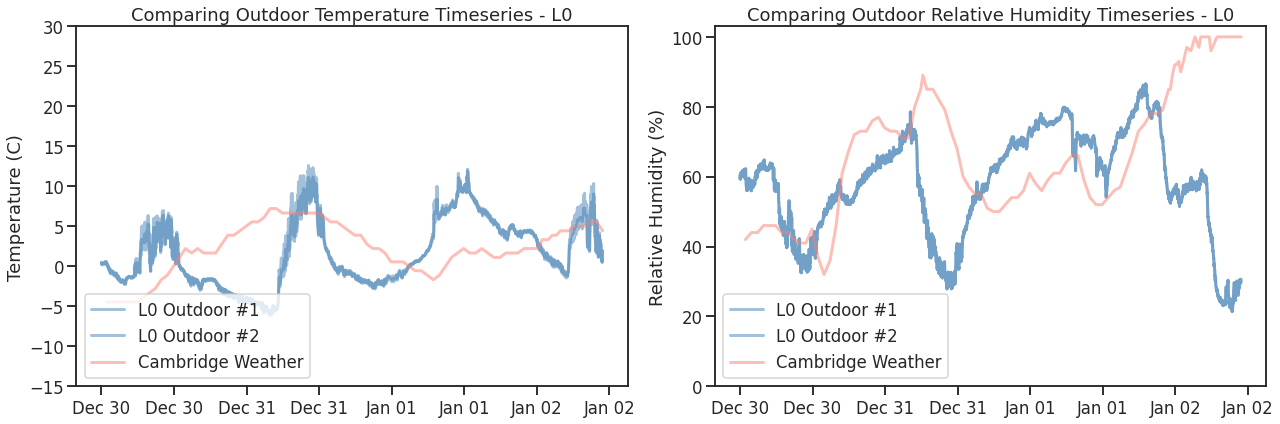

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l0,label='L0 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l0,label='L0 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam_0,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=l0,label='L0 Outdoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_1',data=l0,label='L0 Outdoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam_0,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries - L0')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries - L0')

ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
#[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout()

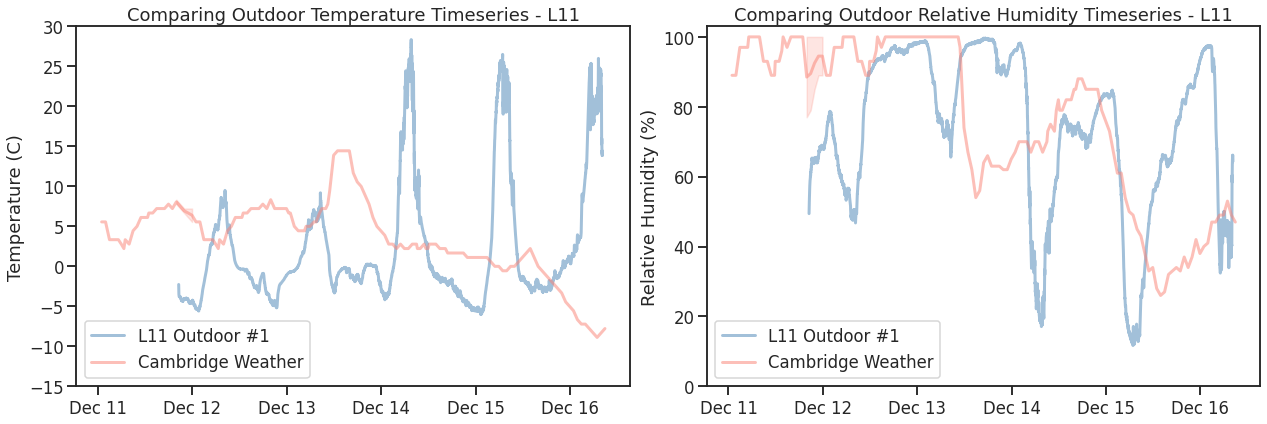

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l11,label='L11 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
#sns.lineplot(x='DateTime',y='T_out_2',data=l11,label='L11 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam_11,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=l11,label='L11 Outdoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
#sns.lineplot(x='DateTime',y='RH_out_1',data=l11,label='L11 Outdoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam_11,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries - L11')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries - L11')

ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
#[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout()

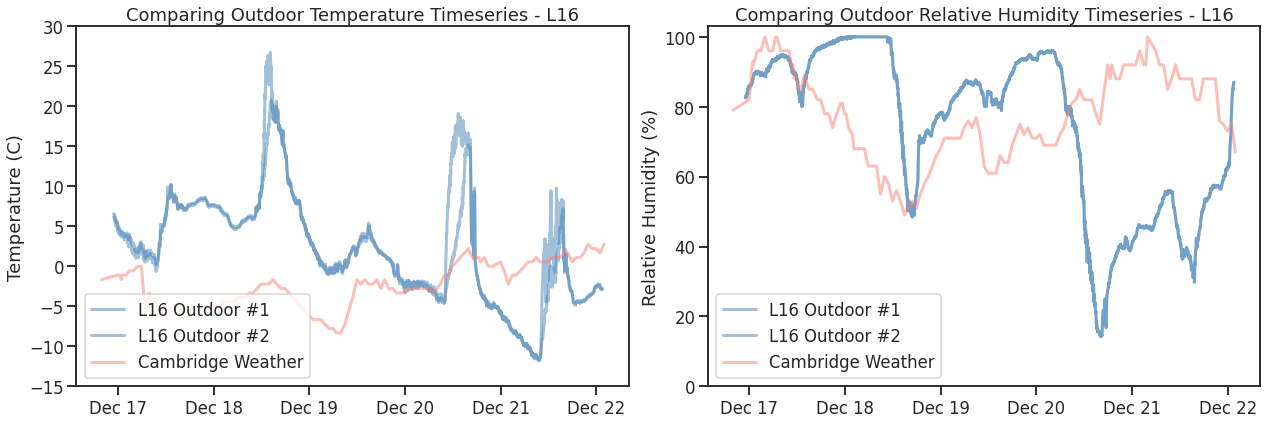

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.lineplot(x='DateTime',y='T_out_1',data=l16,label='L16 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='T_out_2',data=l16,label='L16 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Temp_C',data=cam_16,label='Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

sns.lineplot(x='DateTime',y='RH_out_1',data=l16,label='L16 Outdoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_out_1',data=l16,label='L16 Outdoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='Humidity',data=cam_16,label='Cambridge Weather',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Outdoor Temperature Timeseries - L16')

ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Outdoor Relative Humidity Timeseries - L16')

ax[0].set_ylim(-15,30); ax[1].set_ylim(0,103)

ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

import matplotlib.dates as mdates
#[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Hh")) for ax in plt.gcf().axes]
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout()

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(18,6))
# alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.lineplot(x='DateTime',y='T_out_1',data=l0,label='L0 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='T_out_2',data=l0,label='L0 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='T_in_1',data=l0,label='L0 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='T_in_2',data=l0,label='L0 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# ax[0].set_ylabel('Temperature (C)'); ax[0].set_xlabel('Time (ms)')
# ax[0].set_title('Outdoor Temperature Timeseries - L0')
# ax[1].set_ylabel('Temperature (C)'); ax[1].set_xlabel('Time (ms)')
# ax[1].set_title('Indoor Temperature Timeseries - L0')
# [ax.set_ylim(-15,30) for ax in plt.gcf().axes]
# ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

# import matplotlib.dates as mdates
# [ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
# [ax.set_xlabel('') for ax in plt.gcf().axes]
# fig.tight_layout()


# fig,ax = plt.subplots(1,2,figsize=(18,6))
# alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.lineplot(x='DateTime',y='RH_out_1',data=l0,label='L0 Outdoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='RH_out_2',data=l0,label='L0 Outdoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=outdoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='RH_in_1',data=l0,label='L0 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
# sns.lineplot(x='DateTime',y='RH_in_2',data=l0,label='L0 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)

# ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
# ax[0].set_title('Outdoor Relative Humidity Timeseries - L0')
# ax[1].set_ylabel('Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
# ax[1].set_title('Indoor Relative Humidity Timeseries - L0')

# [ax.set_ylim(0,103) for ax in plt.gcf().axes]
# ax[0].legend(loc='lower left'); ax[1].legend(loc='lower left')

# import matplotlib.dates as mdates
# [ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
# [ax.set_xlabel('') for ax in plt.gcf().axes]
# fig.tight_layout()

In [ ]:
# Define the names of the inner and outer columns that you want to stack 
indoorT_names = ['T_in_1','T_in_2']; indoorRH_names = ['RH_in_1','RH_in_2']
outdoorT_names = ['T_out_1','T_out_2']; outdoorRH_names = ['RH_out_1','RH_out_2']

# Combine and reformat the temperature and relative humidity columns for the indoor sensors
l0_indoorT = l0[indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); l0_indoorT.loc[:,'TName'] = 'T_in'
l0_indoorRH = l0[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l0_indoorRH.loc[:,'RHName'] = 'RH_in'
l11_indoorT = l11[indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); l11_indoorT.loc[:,'TName'] = 'T_in'
l11_indoorRH = l11[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l11_indoorRH.loc[:,'RHName'] = 'RH_in'
l16_indoorT = l16[indoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Indoor T'}); l16_indoorT.loc[:,'TName'] = 'T_in'
l16_indoorRH = l16[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l16_indoorRH.loc[:,'RHName'] = 'RH_in'

# Combine and reformat the temperature and relative humidity columns for the outdoor sensors
l0_outdoorT = l0[outdoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Outdoor T'}); l0_outdoorT.loc[:,'TName'] = 'T_out'
l0_outdoorRH = l0[outdoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Outdoor RH'}); l0_outdoorRH.loc[:,'RHName'] = 'RH_out'
l11_outdoorT = l11['T_out_1'].reset_index().rename(columns={'index': 'TName','T_out_1': 'Outdoor T'}); l11_outdoorT.loc[:,'TName'] = 'T_out'
l11_outdoorRH = l11['RH_out_1'].reset_index().rename(columns={'index': 'RHName','RH_out_1': 'Outdoor RH'}); l11_outdoorRH.loc[:,'RHName'] = 'RH_out'
l16_outdoorT = l16[outdoorT_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'TName',0: 'Outdoor T'}); l16_outdoorT.loc[:,'TName'] = 'T_out'
l16_outdoorRH = l16[outdoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Outdoor RH'}); l16_outdoorRH.loc[:,'RHName'] = 'RH_out'

# Concatenate the dataframes
l0_in_vs_out = pd.concat([l0_indoorT,l0_indoorRH,l0_outdoorT,l0_outdoorRH])#,axis=1)
l11_in_vs_out = pd.concat([l11_indoorT,l11_indoorRH,l11_outdoorT,l11_outdoorRH])#,axis=1)
l16_in_vs_out = pd.concat([l16_indoorT,l16_indoorRH,l16_outdoorT,l16_outdoorRH])#,axis=1)

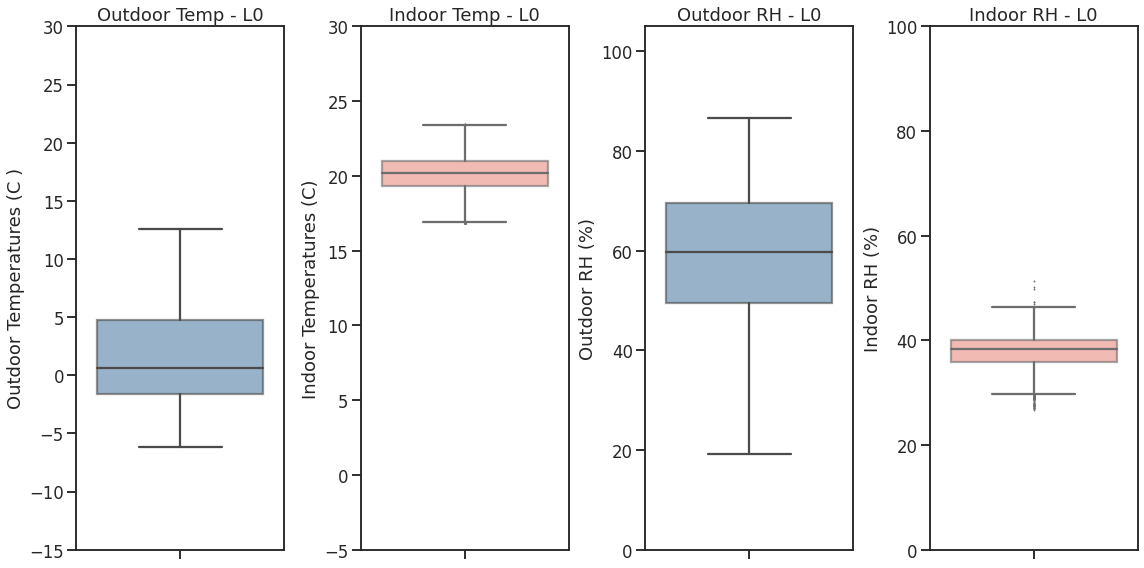

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=l0_in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=l0_in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=l0_in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=l0_in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-15,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,105); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp - L0'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp - L0')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH - L0')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH - L0')

fig.tight_layout()

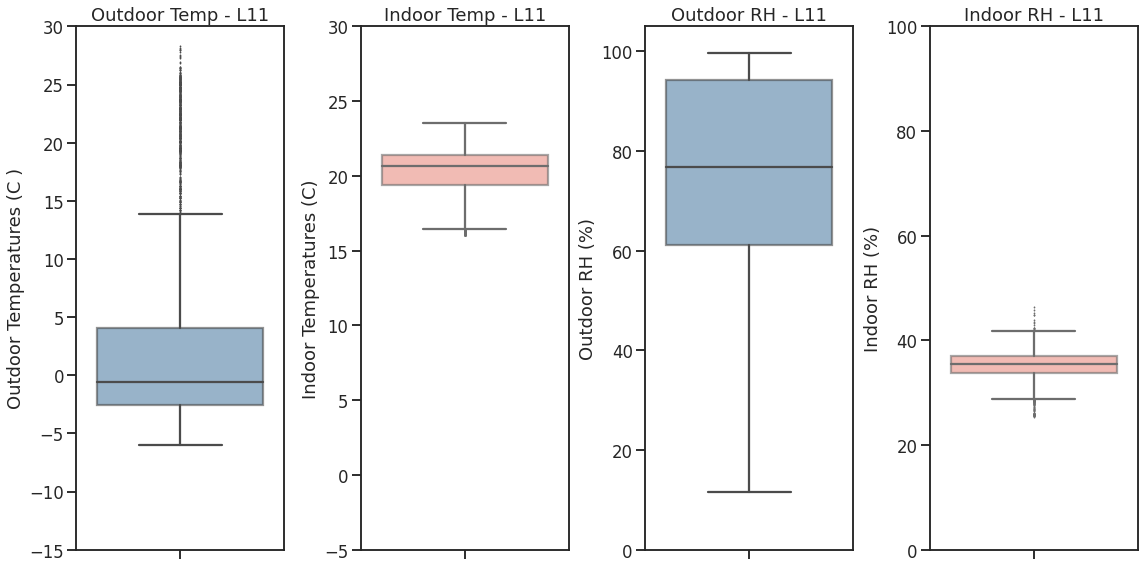

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=l11_in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=l11_in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=l11_in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=l11_in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-15,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,105); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp - L11'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp - L11')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH - L11')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH - L11')

fig.tight_layout()

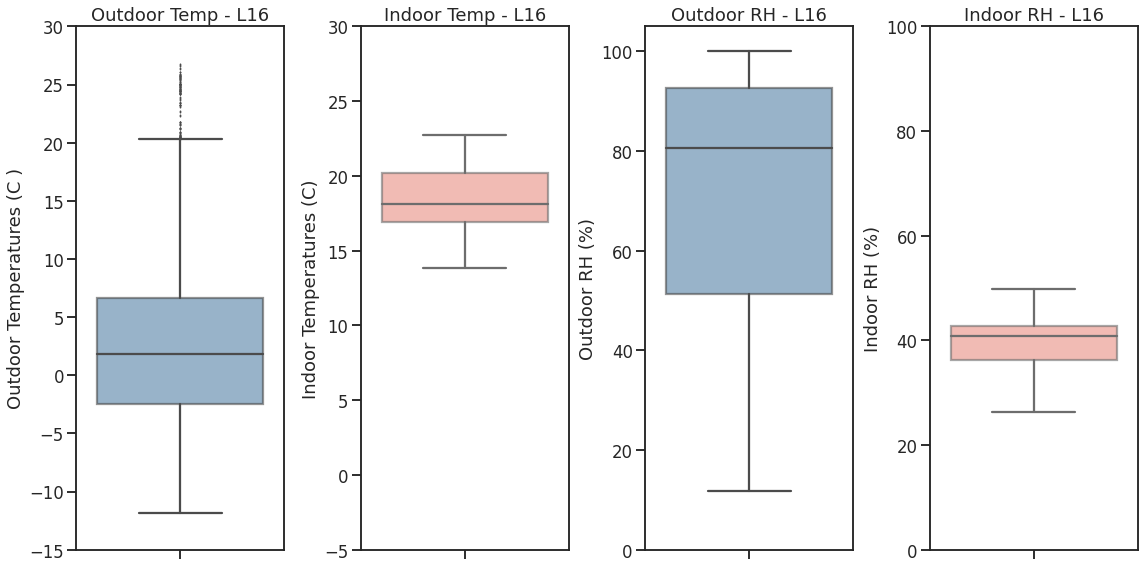

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(16,8))

alpha = 0.6; s=20; linewidth=5; jitter = 0.1; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1

sns.boxplot(y='Outdoor T',data=l16_in_vs_out,ax=ax[0],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor T',data=l16_in_vs_out,ax=ax[1],color=indoor_color,fliersize=fliersize)
sns.boxplot(y='Outdoor RH',data=l16_in_vs_out,ax=ax[2],color=outdoor_color,fliersize=fliersize)
sns.boxplot(y='Indoor RH',data=l16_in_vs_out,ax=ax[3],color=indoor_color,fliersize=fliersize)

[patch.set_alpha(alpha) for i in range(0,4) for patch in ax[i].artists]

ax[0].set_ylim(-15,30); ax[1].set_ylim(-5,30); 
ax[2].set_ylim(0,105); ax[3].set_ylim(0,100); 

ax[0].set_ylabel('Outdoor Temperatures (C )'); ax[0].set_title('Outdoor Temp - L16'); #ax[0].legend(loc='upper left'); 
ax[1].set_ylabel('Indoor Temperatures (C)'); ax[1].set_title('Indoor Temp - L16')
ax[2].set_ylabel('Outdoor RH (%)'); ax[2].set_title('Outdoor RH - L16')
ax[3].set_ylabel('Indoor RH (%)'); ax[3].set_title('Indoor RH - L16')

fig.tight_layout()

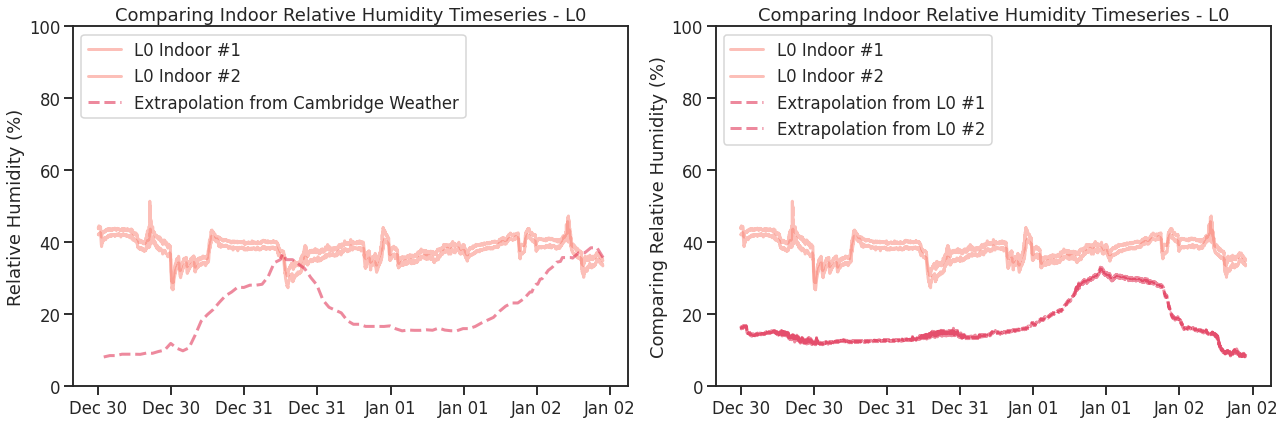

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=l0,label='L0 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l0,label='L0 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam_0,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=l0,label='L0 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l0,label='L0 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=l0,label='Extrapolation from L0 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=l0,label='Extrapolation from L0 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L0')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L0')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

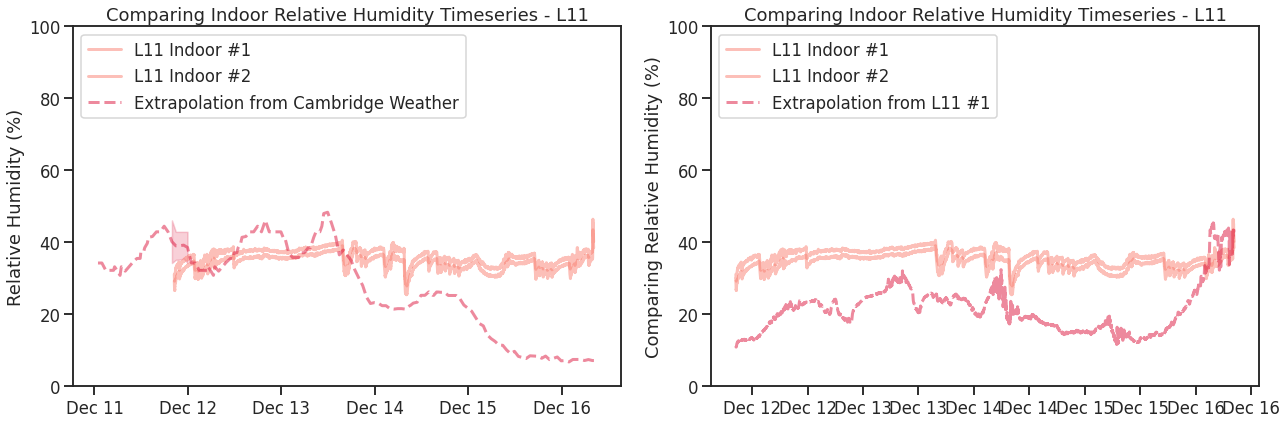

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=l11,label='L11 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l11,label='L11 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam_11,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=l11,label='L11 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l11,label='L11 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=l11,label='Extrapolation from L11 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
#sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=l11,label='Extrapolation from L11 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L11')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L11')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

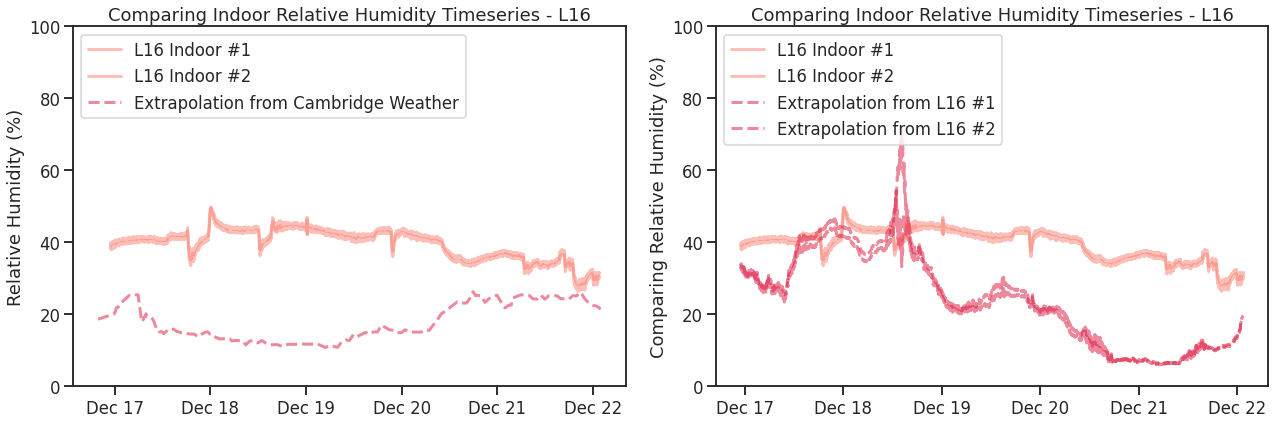

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
alpha = 0.5; s=0; linewidth=3; marker='o'; outdoor_color = 'steelblue'; indoor_color = 'salmon'; indoor_color2 = 'crimson'; linestyle='--'

sns.lineplot(x='DateTime',y='RH_in_1',data=l16,label='L16 Indoor #1',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l16,label='L16 Indoor #2',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=cam_16,label='Extrapolation from Cambridge Weather',ax=ax[0],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

sns.lineplot(x='DateTime',y='RH_in_1',data=l16,label='L16 Indoor #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='RH_in_2',data=l16,label='L16 Indoor #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color,markeredgewidth=0)
sns.lineplot(x='DateTime',y='in_RH_CALC_1',data=l16,label='Extrapolation from L16 #1',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)
sns.lineplot(x='DateTime',y='in_RH_CALC_2',data=l16,label='Extrapolation from L16 #2',ax=ax[1],alpha=alpha,linewidth=linewidth,marker=marker,markersize=s,color=indoor_color2,markeredgewidth=0,linestyle=linestyle)

ax[0].set_ylabel('Relative Humidity (%)'); ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Comparing Indoor Relative Humidity Timeseries - L16')
ax[1].set_ylabel('Comparing Relative Humidity (%)'); ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Comparing Indoor Relative Humidity Timeseries - L16')

[ax.set_ylim(0,100) for ax in plt.gcf().axes]
ax[0].legend(loc='upper left'); ax[1].legend(loc='upper left')

import matplotlib.dates as mdates
[ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) for ax in plt.gcf().axes]; #[ax.tick_params(axis='x', rotation=0) for ax in plt.gcf().axes]
[ax.set_xlabel('') for ax in plt.gcf().axes]
fig.tight_layout()

In [ ]:
# Define the names of the columns that you want to stack 
indoorRH_names = ['RH_in_1','RH_in_2']; indoorRH_ext_names = ['in_RH_CALC_1','in_RH_CALC_2']

# Combine the indoor humidity sensors (duplicate column so you can avoid plotting all 3 on the same graph)
l0_indoorRH = l0[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l0_indoorRH.loc[:,'RHName'] = 'RH_in'
l0_indoorRH2 = l0[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); l0_indoorRH2.loc[:,'RHName2'] = 'RH_in'
l11_indoorRH = l11[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l11_indoorRH.loc[:,'RHName'] = 'RH_in'
l11_indoorRH2 = l11[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); l11_indoorRH2.loc[:,'RHName2'] = 'RH_in'
l16_indoorRH = l16[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l16_indoorRH.loc[:,'RHName'] = 'RH_in'
l16_indoorRH2 = l16[indoorRH_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName2',0: 'Indoor RH2'}); l16_indoorRH2.loc[:,'RHName2'] = 'RH_in'

# Combine the extrapolations based on outdoor sensors and combine the extrapolations based on outdoor cambridge weather 
l0_indoorRH_ext = l0[indoorRH_ext_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l0_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
l0_indoorRH_ext_cam_0 = cam_0[indoorRH_ext_names[0]].reset_index().rename(columns={'index': 'RHName2','in_RH_CALC_1': 'Indoor RH2'}); l0_indoorRH_ext_cam_0.loc[:,'RHName2'] = 'RH_ext_cam'
l11_indoorRH_ext = l11['in_RH_CALC_1'].reset_index().rename(columns={'index': 'RHName','in_RH_CALC_1': 'Indoor RH'}); l11_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
l11_indoorRH_ext_cam_11 = cam_11[indoorRH_ext_names[0]].reset_index().rename(columns={'index': 'RHName2','in_RH_CALC_1': 'Indoor RH2'}); l11_indoorRH_ext_cam_11.loc[:,'RHName2'] = 'RH_ext_cam'
l16_indoorRH_ext = l16[indoorRH_ext_names].unstack().reset_index().drop(columns={'level_1'}).rename(columns={'level_0': 'RHName',0: 'Indoor RH'}); l16_indoorRH_ext.loc[:,'RHName'] = 'RH_ext_sensors'
l16_indoorRH_ext_cam_16 = cam_16[indoorRH_ext_names[0]].reset_index().rename(columns={'index': 'RHName2','in_RH_CALC_1': 'Indoor RH2'}); l16_indoorRH_ext_cam_16.loc[:,'RHName2'] = 'RH_ext_cam'

# Concatenate the dataframes
l0_in_vs_in = pd.concat([l0_indoorRH,l0_indoorRH2,l0_indoorRH_ext,l0_indoorRH_ext_cam_0])#,axis=1)
l11_in_vs_in = pd.concat([l11_indoorRH,l11_indoorRH2,l11_indoorRH_ext,l11_indoorRH_ext_cam_11])#,axis=1)
l16_in_vs_in = pd.concat([l16_indoorRH,l16_indoorRH2,l16_indoorRH_ext,l16_indoorRH_ext_cam_16])#,axis=1)

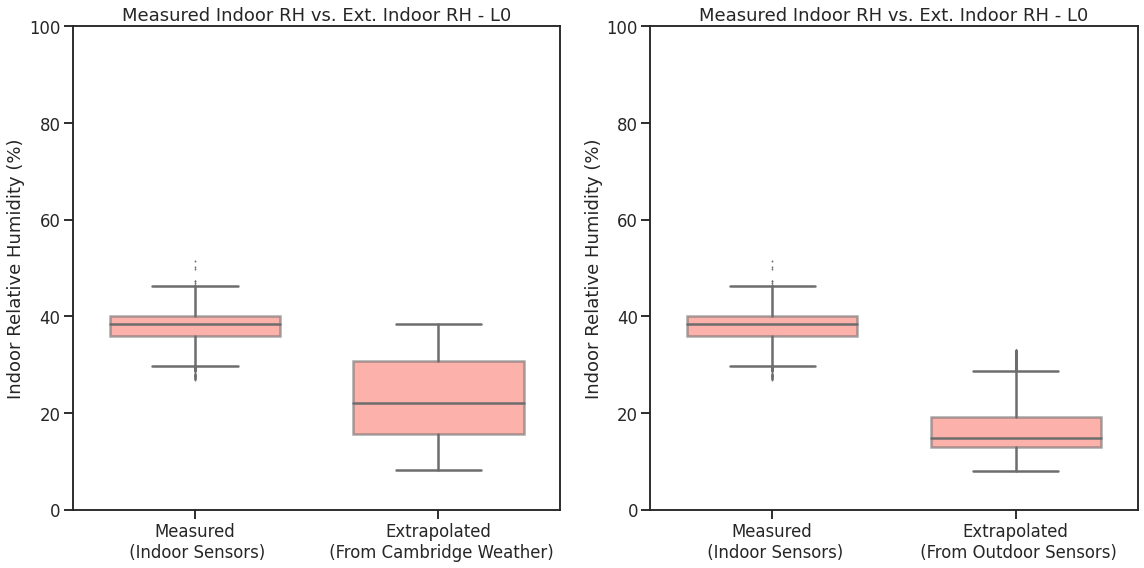

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1; indoor_color2 = 'darkred'

sns.boxplot(x='RHName2',y='Indoor RH2', data=l0_in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Ext. Indoor RH - L0')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=l0_in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Ext. Indoor RH - L0')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]
#[ax[j].artists[i].set_facecolor(indoor_color2) for i in range(1,2) for j in range(0,2)]

fig.tight_layout()

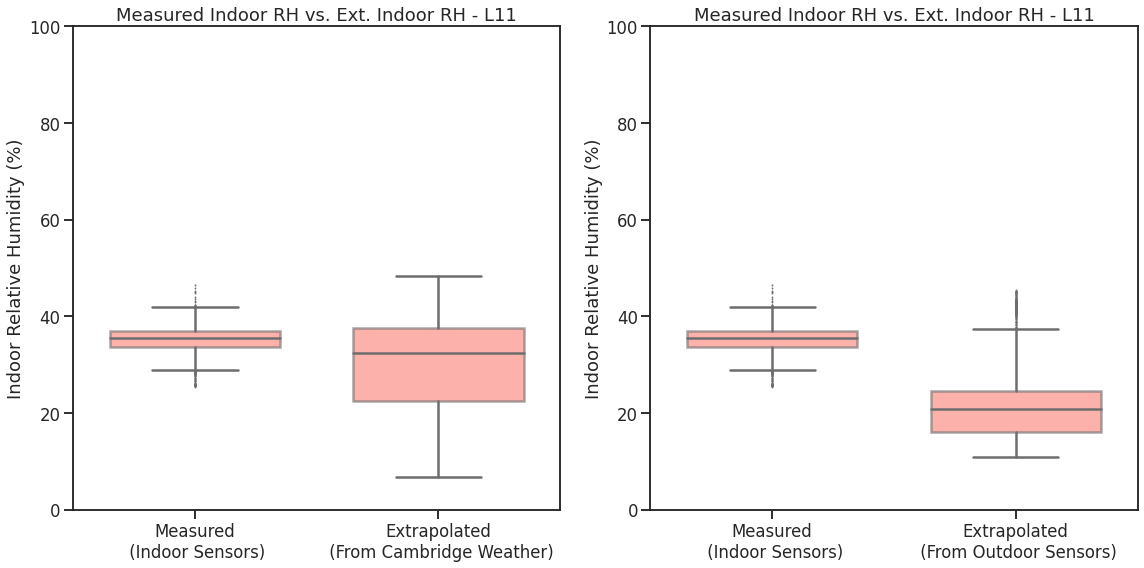

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1; indoor_color2 = 'darkred'

sns.boxplot(x='RHName2',y='Indoor RH2', data=l11_in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Ext. Indoor RH - L11')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=l11_in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Ext. Indoor RH - L11')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]
#[ax[j].artists[i].set_facecolor(indoor_color2) for i in range(1,2) for j in range(0,2)]

fig.tight_layout()

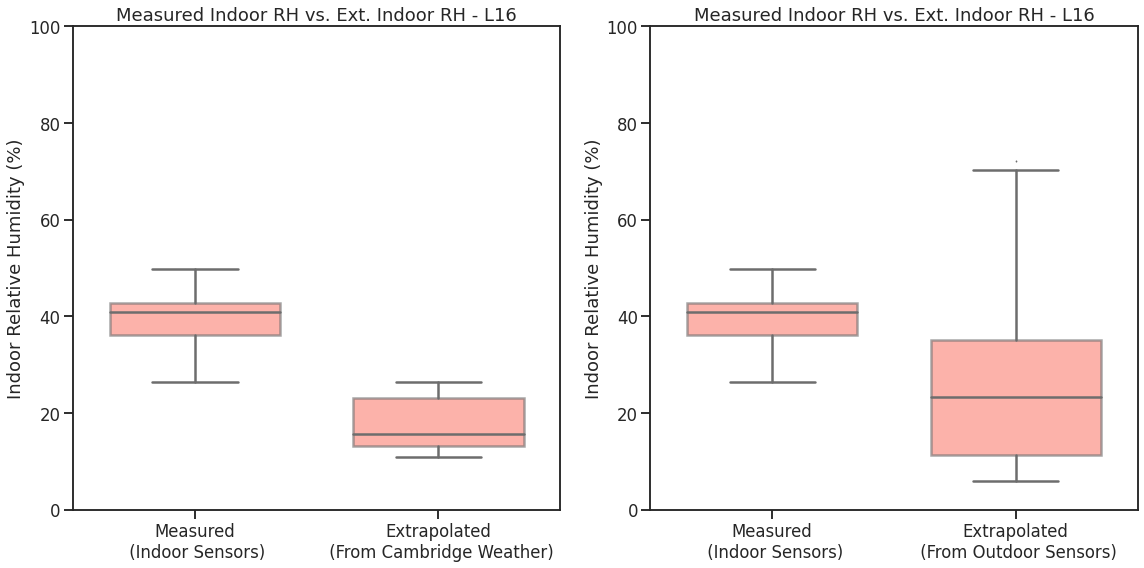

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

alpha = 0.6; s=15; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'; fliersize=1; indoor_color2 = 'darkred'

sns.boxplot(x='RHName2',y='Indoor RH2', data=l16_in_vs_in, width=width,linewidth=linewidth,ax=ax[0],color=indoor_color,fliersize=fliersize)
ax[0].set_ylim(0,100); ax[0].set_ylabel('Indoor Relative Humidity (%)'); ax[0].set_xlabel('')
ax[0].set_title('Measured Indoor RH vs. Ext. Indoor RH - L16')
ax[0].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Cambridge Weather)',])

sns.boxplot(x='RHName',y='Indoor RH', data=l16_in_vs_in, width=width,linewidth=linewidth,ax=ax[1],color=indoor_color,fliersize=fliersize)
ax[1].set_ylim(0,100); ax[1].set_ylabel('Indoor Relative Humidity (%)'); ax[1].set_xlabel('')
ax[1].set_title('Measured Indoor RH vs. Ext. Indoor RH - L16')
ax[1].set_xticklabels(['Measured\n (Indoor Sensors)','Extrapolated\n (From Outdoor Sensors)',])

[patch.set_alpha(alpha) for i in range(0,2) for patch in ax[i].artists]
[ax[j].artists[i].set_facecolor(indoor_color) for i in range(0,2) for j in range(0,2)]
#[ax[j].artists[i].set_facecolor(indoor_color2) for i in range(1,2) for j in range(0,2)]

fig.tight_layout()

### Grouped analysis

In [ ]:
# Can't break the boston dataset into daily datasets because you don't know the exact timeframes when data was collected. Just aggregate everything for this study 

# Break the dset3 and cam3 dataset down into daily subsets 

dset3_daily = {}; cam3_daily = {}

for day in range(5,7+1):
  
  dset3_daily['dec'+str(day)] = dset3[(dset3['DateTime'].gt(datetime(year=2020, month=12, day=day))) & (dset3['DateTime'].lt(datetime(year=2020, month=12, day=day+1)))]
  
  cam3_daily['dec'+str(day)] = cam3[(cam3['DateTime'].gt(datetime(year=2020, month=12, day=day))) & (cam3['DateTime'].lt(datetime(year=2020, month=12, day=day+1)))]


# Break the l1, l2, and cam dataset down into daily subsets 

l1_daily = {}; l2_daily = {}; cam_daily = {}

for day in range(11,17+1):
  
  l1_daily['dec'+str(day)] = l1[(l1['DateTime'].gt(datetime(year=2020, month=12, day=day))) & (l1['DateTime'].lt(datetime(year=2020, month=12, day=day+1)))]
  
  l2_daily['dec'+str(day)] = l2[(l2['DateTime'].gt(datetime(year=2020, month=12, day=day))) & (l2['DateTime'].lt(datetime(year=2020, month=12, day=day+1)))]
 
  cam_daily['dec'+str(day)] = cam[(cam['DateTime'].gt(datetime(year=2020, month=12, day=day))) & (cam['DateTime'].lt(datetime(year=2020, month=12, day=day+1)))]

In [ ]:
# Initialize lists to store all of the mean values, along with a list to store the difference between means 
measured_indoorRH_means = []; extrapolated_indoorRH_means = []; diff_between_means = []


# Adding the weeklong means for the Boston hospital study (since you don't have the information necessary for a day-by-day breakdown) 

measured_mean = bos_indoor.iloc[:,4:].stack().mean()

extrapolated_mean = bos_outdoor['in_RH_CALC_1'].mean()

measured_indoorRH_means.append(measured_mean); extrapolated_indoorRH_means.append(extrapolated_mean)

diff_between_means.append(measured_mean-extrapolated_mean)


# Adding the daily means for the dset3 study (48hrs of data collection)

for day in range(5,7+1):
  
  measured_mean = dset3_daily['dec'+str(day)][dset3_indoorRH_names].stack().mean()
  
  extrapolated_mean = cam3_daily['dec'+str(day)][['in_RH_CALC_1']].stack().mean()
  
  measured_indoorRH_means.append(measured_mean); extrapolated_indoorRH_means.append(extrapolated_mean)

  diff_between_means.append(measured_mean-extrapolated_mean)


# Adding the daily means for the l1 and l2 study (multiple days of data collection, although l1 stops slightly earlier than l2)

for day in range(11,17+1):
  
  measured_mean = l1_daily['dec'+str(day)][indoorRH_names].stack().mean()

  measured_mean2 = l2_daily['dec'+str(day)][indoorRH_names].stack().mean()
  
  extrapolated_mean = cam_daily['dec'+str(day)][['in_RH_CALC_1']].stack().mean()
  
  measured_indoorRH_means.append(measured_mean); measured_indoorRH_means.append(measured_mean2); extrapolated_indoorRH_means.append(extrapolated_mean)

  diff_between_means.append(measured_mean-extrapolated_mean); diff_between_means.append(measured_mean2-extrapolated_mean)


# Compile all of the results into a dataframe 
m = pd.DataFrame(columns={'Measured'},data=measured_indoorRH_means)
e = pd.DataFrame(columns={'Extrapolated'},data=extrapolated_indoorRH_means)
error = pd.DataFrame(columns={'RawError'},data=diff_between_means)

compiled = pd.concat([m,e,error],axis=1)

Text(0.5, 0, '')

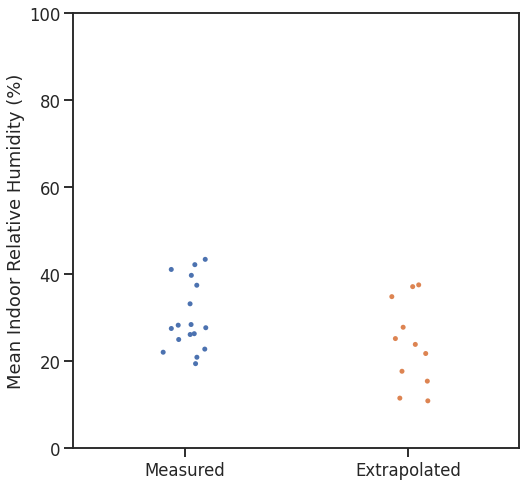

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.stripplot(data=compiled.iloc[:,:2])#, width=width,linewidth=linewidth)
ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')


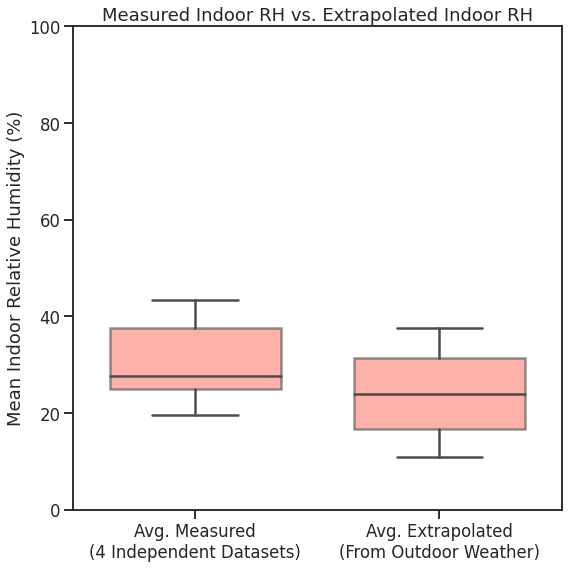

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.boxplot(data=compiled.iloc[:,:2], width=width,linewidth=linewidth)

ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')
ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax.set_xticklabels(['Avg. Measured\n(4 Independent Datasets)','Avg. Extrapolated\n(From Outdoor Weather)',])
    
[patch.set_alpha(alpha) for patch in ax.artists]
[ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

fig.tight_layout()

In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

print('Mean indoor relative humidity measured by indoor sensors:',round(compiled['Measured'].mean(),2),'+/-',round( compiled['Measured'].std(),2))

print('\nMedian indoor relative humidity measured by indoor sensors:',round(compiled['Measured'].median(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(compiled['Extrapolated'].mean(),2),'+/-',round(compiled['Extrapolated'].std(),2))

print('\nMedian indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(compiled['Extrapolated'].median(),2),'+/-')


print('\nAverage difference in means between measured and extrapolated:',round(compiled['RawError'].mean(),2))

print('\n95% confidence intervals for difference in means between measured and extrapolated:',round(sms.DescrStatsW(compiled['RawError'].dropna()).tconfint_mean()[0],2),'to',round(sms.DescrStatsW(compiled['RawError'].dropna()).tconfint_mean()[1],2))

Mean indoor relative humidity measured by indoor sensors: 30.13 +/- 7.88

Median indoor relative humidity measured by indoor sensors: 27.73

Mean indoor relative humidity estimated by extrapolation workflow from outdoor weather: 24.0 +/- 9.68

Median indoor relative humidity estimated by extrapolation workflow from outdoor weather: 23.89 +/-

Average difference in means between measured and extrapolated: 5.43

95% confidence intervals for difference in means between measured and extrapolated: 0.24 to 10.61


In [ ]:
# Looking at absolute error vs. raw error 
print('\nAverage difference in means between measured and extrapolated:',round(compiled['RawError'].abs().mean(),2))

print('\n95% confidence intervals for difference in means between measured and extrapolated:',round(sms.DescrStatsW(compiled['RawError'].abs().dropna()).tconfint_mean()[0],2),'to',round(sms.DescrStatsW(compiled['RawError'].abs().dropna()).tconfint_mean()[1],2))


Average difference in means between measured and extrapolated: 8.68

95% confidence intervals for difference in means between measured and extrapolated: 4.94 to 12.42


In [ ]:
# Same analysis but only get a single averaged datapoint for each of the datasets

measured_indoorRH_means2 = [bos_indoor.iloc[:,4:].stack().mean(), 
                            dset3[dset3_indoorRH_names].stack().mean(), 
                            l1[indoorRH_names].stack().mean(), 
                            l2[indoorRH_names].stack().mean()]

extrapolated_indoorRH_means2 = [bos_outdoor['in_RH_CALC_1'].mean(), 
                                cam3[['in_RH_CALC_1']].stack().mean(), 
                                cam[['in_RH_CALC_1']].stack().mean(), 
                                cam[['in_RH_CALC_1']].stack().mean()]

diff_between_means2 = np.array(measured_indoorRH_means2) - np.array(extrapolated_indoorRH_means2)

# Compile into a dataframe 
m2 = pd.DataFrame(columns={'Measured'},data=measured_indoorRH_means2)
e2 = pd.DataFrame(columns={'Extrapolated'},data=extrapolated_indoorRH_means2)
names = pd.DataFrame(columns={'Datasets'},data=['Boston Hospital','Dataset #3','Dataset L1', 'Dataset L2'])
error2 = pd.DataFrame(columns={'RawError'},data=diff_between_means2)

compiled2 = pd.concat([m2,e2,names,error2],axis=1)
compiled2

Measured  Extrapolated         Datasets   RawError
0  26.166667     27.835582  Boston Hospital  -1.668915
1  23.721937     16.861217       Dataset #3   6.860720
2  39.562680     25.554477       Dataset L1  14.008203
3  25.226694     25.554477       Dataset L2  -0.327782

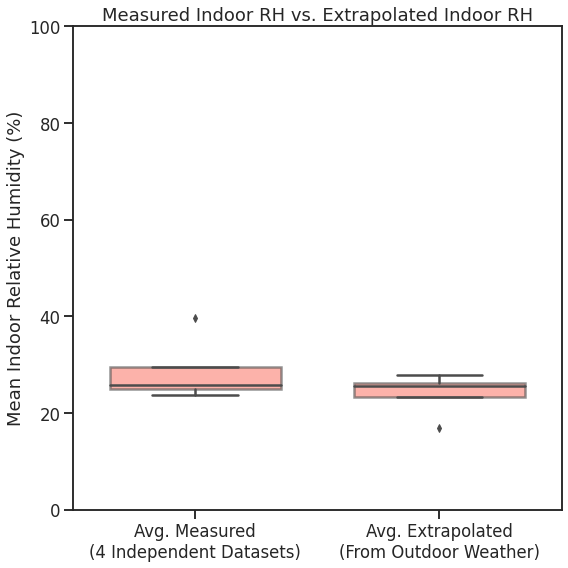

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.boxplot(data=compiled2.iloc[:,:2], width=width,linewidth=linewidth)

ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')
ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax.set_xticklabels(['Avg. Measured\n(4 Independent Datasets)','Avg. Extrapolated\n(From Outdoor Weather)',])
    
[patch.set_alpha(alpha) for patch in ax.artists]
[ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

fig.tight_layout()

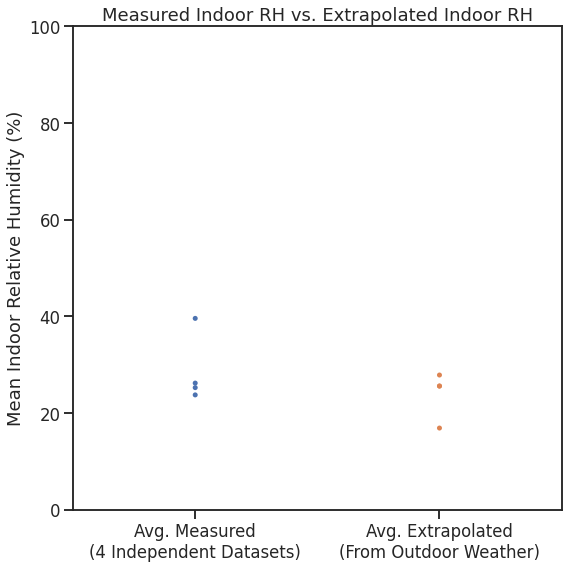

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.stripplot(data=compiled2.iloc[:,:2],jitter=0)

ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')
ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax.set_xticklabels(['Avg. Measured\n(4 Independent Datasets)','Avg. Extrapolated\n(From Outdoor Weather)',])
    
# [patch.set_alpha(alpha) for patch in ax.artists]
# [ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

fig.tight_layout()

In [ ]:
# fig,ax = plt.subplots(figsize=(8,8))

# alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# #sns.pointplot(x='Datasets',y='Measured',data=compiled2,)
# #sns.pointplot(x='Datasets',y='Extrapolated',data=compiled2,)

# sns.boxplot(x='level_1',y=0,hue='level_0',data=compiled2.iloc[:,:2].unstack().reset_index())#, width=width,linewidth=linewidth)

# ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')
# # ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
# # ax.set_xticklabels(['Avg. Measured\n(4 Independent Datasets)','Avg. Extrapolated\n(From Outdoor Weather)',])
    
# # [patch.set_alpha(alpha) for patch in ax.artists]
# # [ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

# fig.tight_layout()

In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

print('Mean indoor relative humidity measured by indoor sensors:',round(compiled2['Measured'].mean(),2),'+/-',round( compiled2['Measured'].std(),2))

print('\nMedian indoor relative humidity measured by indoor sensors:',round(compiled2['Measured'].median(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(compiled2['Extrapolated'].mean(),2),'+/-',round(compiled2['Extrapolated'].std(),2))

print('\nMedian indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(compiled2['Extrapolated'].median(),2),'+/-')


print('\nAverage difference in means between measured and extrapolated:',round(compiled2['RawError'].mean(),2))

print('\n95% confidence intervals for difference in means between measured and extrapolated:',round(sms.DescrStatsW(compiled2['RawError'].dropna()).tconfint_mean()[0],2),'to',round(sms.DescrStatsW(compiled2['RawError'].dropna()).tconfint_mean()[1],2))


Mean indoor relative humidity measured by indoor sensors: 28.67 +/- 7.33

Median indoor relative humidity measured by indoor sensors: 25.7

Mean indoor relative humidity estimated by extrapolation workflow from outdoor weather: 23.95 +/- 4.85

Median indoor relative humidity estimated by extrapolation workflow from outdoor weather: 25.55 +/-

Average difference in means between measured and extrapolated: 4.72

95% confidence intervals for difference in means between measured and extrapolated: -6.8 to 16.23


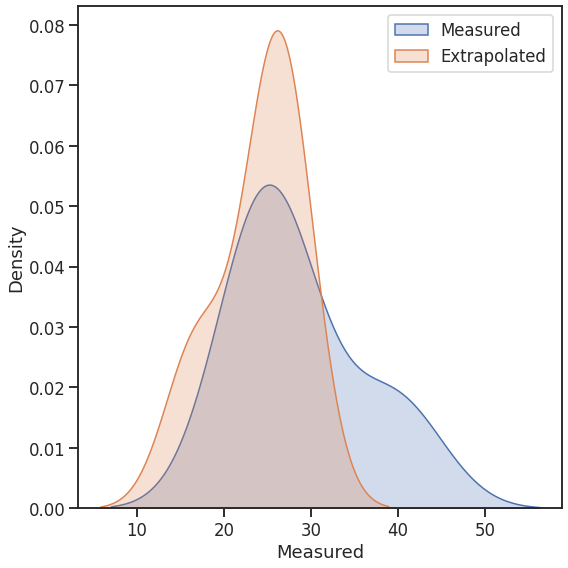

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

sns.kdeplot(compiled2['Measured'],fill=True,label='Measured',)
sns.kdeplot(compiled2['Extrapolated'],fill=True,label='Extrapolated')

ax.legend()
fig.tight_layout()

### Change in RH with different assumed thermal comf temps 

In [ ]:
outdoorAHarray = np.arange(2,9,1)
thermalcomfarray = np.arange(19,25,1)

# Initialize an empty dataframe where all of the indices are temperature values and all of the columns are dewpoint values 
df = pd.DataFrame(index=thermalcomfarray,columns=outdoorAHarray)

# Go through each of the temperature values 
for Thermal_Comfort_Temp in df.index:

  # Go through each of the dewpoint values 
  for AbsHum in df.columns:

    estimated_indoor_RH = indoor_rh_calc(0, Thermal_Comfort_Temp, AbsHum)

    df.loc[Thermal_Comfort_Temp,AbsHum] = float(estimated_indoor_RH)

df

2        3        4        5        6        7        8
19  12.3027   18.454  24.6054  30.7567   36.908  43.0594  49.2107
20  11.5905  17.3857   23.181  28.9762  34.7715  40.5667   46.362
21   10.924   16.386   21.848  27.3101  32.7721  38.2341  43.6961
22  10.3004  15.4506  20.6007  25.7509  30.9011  36.0513  41.2015
23  9.71682  14.5752  19.4336   24.292  29.1505  34.0089  38.8673
24  9.17075  13.7561  18.3415  22.9269  27.5123  32.0976   36.683

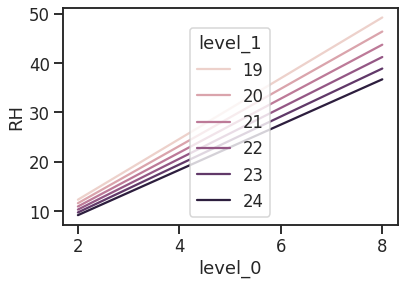

In [ ]:
sns.lineplot(x='level_0',y='RH',hue='level_1',data=df.astype(float).unstack().reset_index().rename(columns={0:'RH'}))

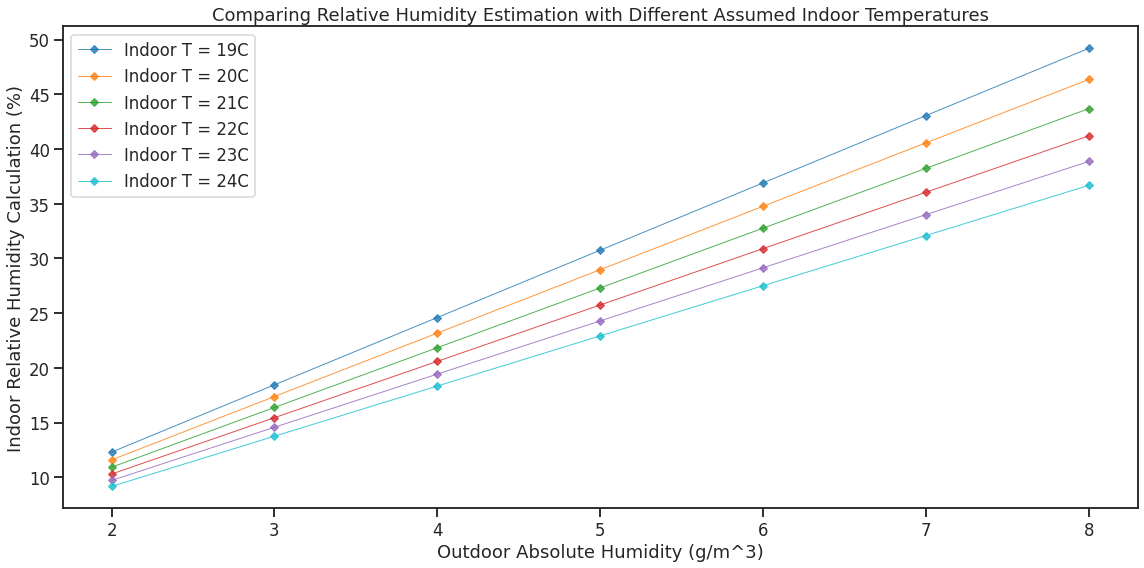

In [ ]:
fig,ax=plt.subplots(figsize=(16,8))

alpha = 0.8; s=5; linewidth=1; marker='D'

ax.plot(df.T,alpha=alpha,linewidth=linewidth,marker=marker,markersize=s)

ax.set_ylabel('Indoor Relative Humidity Calculation (%)'); ax.set_xlabel('Outdoor Absolute Humidity (g/m^3)')
ax.set_title('Comparing Relative Humidity Estimation with Different Assumed Indoor Temperatures')

from matplotlib.lines import Line2D
customlegend = [Line2D([0], [0],color='tab:blue',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='tab:orange',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='tab:green',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='tab:red',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='tab:purple',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),
                Line2D([0], [0],color='tab:cyan',alpha=alpha,linewidth=linewidth,marker=marker,markersize=s),]

ax.legend(customlegend, ['Indoor T = 19C','Indoor T = 20C','Indoor T = 21C','Indoor T = 22C','Indoor T = 23C','Indoor T = 24C'],loc='upper left')

plt.gca().get_lines()[0].set_color('tab:blue')
plt.gca().get_lines()[1].set_color('tab:orange')
plt.gca().get_lines()[2].set_color('tab:green')
plt.gca().get_lines()[3].set_color('tab:red')
plt.gca().get_lines()[4].set_color('tab:purple')
plt.gca().get_lines()[5].set_color('tab:cyan')

fig.tight_layout()

### Grouped for Paper

In [ ]:
# Get means for each hospital 
bos_indoor_means = bos_indoor.mean().reset_index().rename(columns={'index':'Hospital',0:'Value'})
bos_indoor_means#[3:]

# Get means for each day of weather 
bos_outdoor_means = bos_outdoor.set_index(bos_outdoor['DateTime']).resample('D').mean()
bos_outdoor_means

Humidity    Temp_C  out_AH_1  in_RH_CALC_1
DateTime                                               
2020-03-30  93.000000  4.074074  5.943091     32.461227
2020-03-31  77.000000  1.666667  4.181625     22.840077
2020-04-01  76.000000  2.444444  4.345304     23.734093
2020-04-02  74.666667  5.000000  5.071536     27.700784
2020-04-03  89.000000  6.666667  6.744993     36.841223

In [ ]:
# fig,ax = plt.subplots(1,4,figsize=(13,6))

# alpha = 0.7; s=15; linewidth=8; jitter = 0.; outdoor_color = 'steelblue'; indoor_color = 'salmon'

# sns.stripplot(y='Temp_C',data=bos_resampled_means,label='Boston\nWeather',ax=ax[0],color=outdoor_color,s=s,alpha=alpha,marker='o',jitter=jitter)
# ax[0].axhline(y=bos_resampled_means.mean()['Temp_C'],xmin=0.2,xmax=.8,color=outdoor_color,alpha=alpha,linewidth=linewidth)
# sns.stripplot(y='Value',data=bos_indoor_means[:3],label='Hospitals',ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='o',jitter=jitter)
# ax[1].axhline(y=bos_indoor_means[:3].mean().values,xmin=0.2,xmax=.8,color=indoor_color,alpha=alpha,linewidth=linewidth)

# sns.stripplot(y='Humidity',data=bos_resampled_means,label='Boston\nWeather',ax=ax[2],color=outdoor_color,s=s,alpha=alpha,marker='o',jitter=jitter)
# ax[2].axhline(y=bos_resampled_means.mean()['Humidity'],xmin=0.2,xmax=.8,color=outdoor_color,alpha=alpha,linewidth=linewidth)
# sns.stripplot(y='Value',data=bos_indoor_means[3:],label='Hospitals',ax=ax[3],color=indoor_color,s=s,alpha=alpha,marker='o',jitter=jitter)
# ax[3].axhline(y=bos_indoor_means[3:].mean().values,xmin=0.2,xmax=.8,color=indoor_color,alpha=alpha,linewidth=linewidth)

# ax[0].set_ylim(-5,30); ax[1].set_ylim(-5,30); 
# ax[2].set_ylim(0,100); ax[3].set_ylim(0,100); 

# ax[0].legend(loc='upper left'); ax[0].set_ylabel('Mean Outdoor Temp (C)'); ax[0].set_title('Outdoor Temp')
# ax[1].legend(loc='lower left'); ax[1].set_ylabel('Mean Indoor Temp (C)'); ax[1].set_title('Indoor Temp')
# ax[2].legend(loc='lower left'); ax[2].set_ylabel('Mean Outdoor RH (%)'); ax[2].set_title('Outdoor Humidity')
# ax[3].legend(loc='upper left'); ax[3].set_ylabel('Mean Indoor RH (%)'); ax[3].set_title('Indoor Humidity')

# fig.tight_layout()

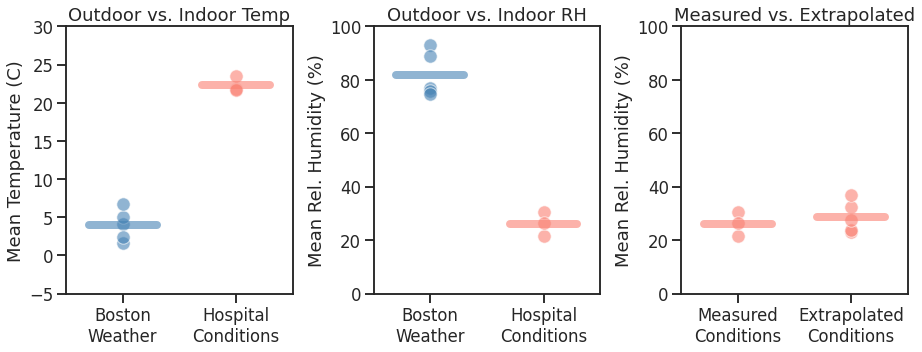

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(13,5))

alpha = 0.6; s=180; linewidth=8; jitter = 0.; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.scatterplot(x=np.zeros(bos_outdoor_means['Temp_C'].values.shape[0]),y=bos_outdoor_means['Temp_C'].values,ax=ax[0],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=bos_outdoor_means.mean()['Temp_C'],xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(bos_indoor_means[:3]['Value'].values.shape[0]),y=bos_indoor_means[:3]['Value'].values,ax=ax[0],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=bos_indoor_means[:3].mean().values,xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(bos_outdoor_means['Humidity'].values.shape[0]),y=bos_outdoor_means['Humidity'].values,ax=ax[1],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=bos_outdoor_means.mean()['Humidity'],xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(bos_indoor_means[3:]['Value'].values.shape[0]),y=bos_indoor_means[3:]['Value'].values,ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=bos_indoor_means[3:].mean().values,xmin=0.6,xmax=0.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(bos_indoor_means[3:]['Value'].values.shape[0]),y=bos_indoor_means[3:]['Value'].values,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=bos_indoor_means[3:].mean().values,xmin=0.1,xmax=0.4,color=indoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(bos_outdoor_means['in_RH_CALC_1'].values.shape[0]),y=bos_outdoor_means['in_RH_CALC_1'].values,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=bos_outdoor_means.mean()['in_RH_CALC_1'],xmin=0.6,xmax=0.9,color=indoor_color,alpha=alpha,linewidth=linewidth)


ax[0].set_xlim(-0.5,1.5); ax[1].set_xlim(-0.5,1.5); ax[2].set_xlim(-0.5,1.5);  
ax[0].set_ylim(-5,30); ax[1].set_ylim(0,100); ax[2].set_ylim(0,100)
ax[0].set_xticks([0,1]); ax[0].set_xticklabels(['Boston\nWeather','Hospital\nConditions'])
ax[1].set_xticks([0,1]); ax[1].set_xticklabels(['Boston\nWeather','Hospital\nConditions'])
ax[2].set_xticks([0,1]); ax[2].set_xticklabels(['Measured\nConditions','Extrapolated\nConditions'])

ax[0].set_ylabel('Mean Temperature (C)'); ax[1].set_ylabel('Mean Rel. Humidity (%)'); ax[2].set_ylabel('Mean Rel. Humidity (%)')
ax[0].set_title('Outdoor vs. Indoor Temp'); ax[1].set_title('Outdoor vs. Indoor RH'); ax[2].set_title('Measured vs. Extrapolated')

fig.tight_layout()

In [ ]:
# 48hrs (48hrs) resample to get daily means
means_48h = dset3.set_index(dset3['DateTime']).resample('D').mean()
cam_means_48h = cam3.set_index(cam3['DateTime']).resample('D').mean()

# L0 (L0_122920_115pm) resample to get daily means
means_l0 = l0.set_index(l0['DateTime']).resample('D').mean()
cam_means_l0 = cam_0.set_index(cam_0['DateTime']).resample('D').mean()

# L1 (L1_12112020_830pm) resample to get daily means
means_l1 = l11.set_index(l11['DateTime']).resample('D').mean()
cam_means_l1 = cam_11.set_index(cam_11['DateTime']).resample('D').mean()

# L2 (L2_121120_950pm) resample to get daily means
means_l2 = l2.set_index(l2['DateTime']).resample('D').mean()
cam_means_l2 = cam.set_index(cam['DateTime']).resample('D').mean()

In [ ]:
indoor_tmeans = np.concatenate((means_48h[['T_in_1','T_in_2','T_in_3','T_in_4']].stack().values,
                                means_l0[['T_in_1','T_in_2']].stack().values,
                                means_l1[['T_in_1','T_in_2']].stack().values,
                                means_l2[['T_in_1','T_in_2']].stack().values))

In [ ]:
outdoor_tmeans = np.concatenate((cam_means_48h[['Temp_C']].stack().values,
                                cam_means_l0[['Temp_C']].stack().values,
                                cam_means_l1[['Temp_C']].stack().values,
                                cam_means_l2[['Temp_C']].stack().values))

In [ ]:
indoor_rhmeans = np.concatenate((means_48h[['RH_in_1','RH_in_2','RH_in_3','RH_in_4']].stack().values,
                                means_l0[['RH_in_1','RH_in_2']].stack().values,
                                means_l1[['RH_in_1','RH_in_2']].stack().values,
                                means_l2[['RH_in_1','RH_in_2']].stack().values))

In [ ]:
outdoor_rhmeans = np.concatenate((cam_means_48h[['Humidity']].stack().values,
                                cam_means_l0[['Humidity']].stack().values,
                                cam_means_l1[['Humidity']].stack().values,
                                cam_means_l2[['Humidity']].stack().values))

In [ ]:
extrapolation_rhmeans = np.concatenate((cam_means_48h[['in_RH_CALC_1']].stack().values,
                                cam_means_l0[['in_RH_CALC_1']].stack().values,
                                cam_means_l1[['in_RH_CALC_1']].stack().values,
                                cam_means_l2[['in_RH_CALC_1']].stack().values))

In [ ]:
extrapolation_rhmeans

array([25.23297383, 17.71604601, 15.44490815, 14.3876155 , 25.61136866,
       19.17807594, 34.7330642 , 37.19105603, 37.57718629, 37.17588636,
       23.89037782, 10.91152927,  7.24538757, 34.87427444, 37.57718629,
       37.17588636, 23.89037782, 10.91152927, 11.53718725, 21.79791233])

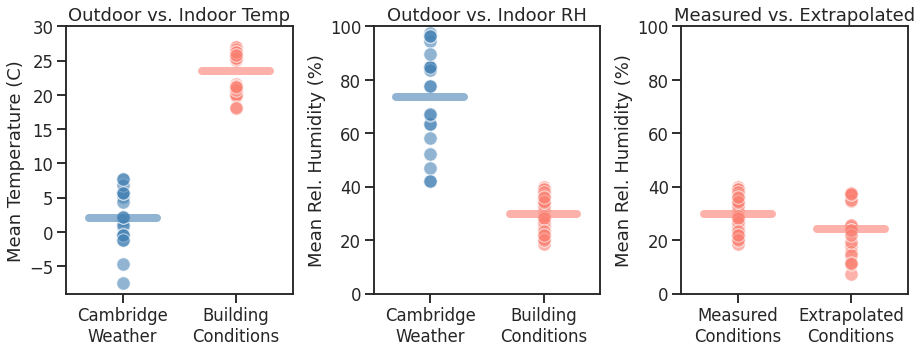

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(13,5))

alpha = 0.6; s=180; linewidth=8; jitter = 0.; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.scatterplot(x=np.zeros(outdoor_tmeans.shape[0]),y=outdoor_tmeans,ax=ax[0],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=outdoor_tmeans.mean(),xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(indoor_tmeans.shape[0]),y=indoor_tmeans,ax=ax[0],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=indoor_tmeans.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(outdoor_rhmeans.shape[0]),y=outdoor_rhmeans,ax=ax[1],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=outdoor_rhmeans.mean(),xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(indoor_rhmeans.shape[0]),y=indoor_rhmeans,ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=indoor_rhmeans.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(indoor_rhmeans.shape[0]),y=indoor_rhmeans,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=indoor_rhmeans.mean(),xmin=.1,xmax=.4,color=indoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(extrapolation_rhmeans.shape[0]),y=extrapolation_rhmeans,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=extrapolation_rhmeans.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

ax[0].set_xlim(-0.5,1.5); ax[1].set_xlim(-0.5,1.5); ax[2].set_xlim(-0.5,1.5);  
ax[0].set_ylim(-9,30); ax[1].set_ylim(0,100); ax[2].set_ylim(0,100)
ax[0].set_xticks([0,1]); ax[0].set_xticklabels(['Cambridge\nWeather','Building\nConditions'])
ax[1].set_xticks([0,1]); ax[1].set_xticklabels(['Cambridge\nWeather','Building\nConditions'])
ax[2].set_xticks([0,1]); ax[2].set_xticklabels(['Measured\nConditions','Extrapolated\nConditions'])

ax[0].set_ylabel('Mean Temperature (C)'); ax[1].set_ylabel('Mean Rel. Humidity (%)'); ax[2].set_ylabel('Mean Rel. Humidity (%)')
ax[0].set_title('Outdoor vs. Indoor Temp'); ax[1].set_title('Outdoor vs. Indoor RH'); ax[2].set_title('Measured vs. Extrapolated')

fig.tight_layout()

In [ ]:
outdoor_T = np.concatenate((bos_outdoor_means['Temp_C'].values, 
                outdoor_tmeans))
outdoor_RH = np.concatenate((bos_outdoor_means['Humidity'].values, 
                 outdoor_rhmeans))
indoor_T = np.concatenate((bos_indoor_means[:3]['Value'].values, 
                indoor_tmeans))
indoor_RH = np.concatenate((bos_indoor_means[3:]['Value'].values,
                indoor_rhmeans))
ext_RH = np.concatenate((bos_outdoor_means['in_RH_CALC_1'],
                         extrapolation_rhmeans))

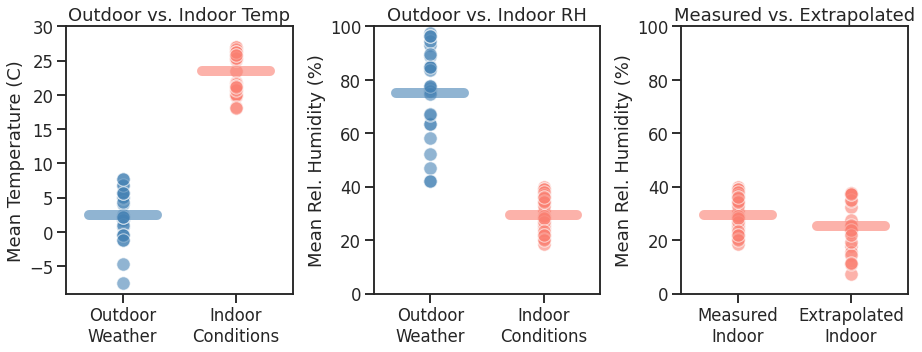

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(13,5))

alpha = 0.6; s=180; linewidth=10; jitter = 0.; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.scatterplot(x=np.zeros(outdoor_T.shape[0]),y=outdoor_T,ax=ax[0],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=outdoor_T.mean(),xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(indoor_T.shape[0]),y=indoor_T,ax=ax[0],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[0].axhline(y=indoor_T.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(outdoor_RH.shape[0]),y=outdoor_RH,ax=ax[1],color=outdoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=outdoor_RH.mean(),xmin=0.1,xmax=0.4,color=outdoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(indoor_RH.shape[0]),y=indoor_RH,ax=ax[1],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[1].axhline(y=indoor_RH.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

sns.scatterplot(x=np.zeros(indoor_RH.shape[0]),y=indoor_RH,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=indoor_RH.mean(),xmin=.1,xmax=.4,color=indoor_color,alpha=alpha,linewidth=linewidth)
sns.scatterplot(x=np.ones(ext_RH.shape[0]),y=ext_RH,ax=ax[2],color=indoor_color,s=s,alpha=alpha,marker='o')
ax[2].axhline(y=ext_RH.mean(),xmin=.6,xmax=.9,color=indoor_color,alpha=alpha,linewidth=linewidth)

ax[0].set_xlim(-0.5,1.5); ax[1].set_xlim(-0.5,1.5); ax[2].set_xlim(-0.5,1.5);  
ax[0].set_ylim(-9,30); ax[1].set_ylim(0,100); ax[2].set_ylim(0,100)
ax[0].set_xticks([0,1]); ax[0].set_xticklabels(['Outdoor\nWeather','Indoor\nConditions'])
ax[1].set_xticks([0,1]); ax[1].set_xticklabels(['Outdoor\nWeather','Indoor\nConditions'])
ax[2].set_xticks([0,1]); ax[2].set_xticklabels(['Measured\nIndoor','Extrapolated\nIndoor'])

ax[0].set_ylabel('Mean Temperature (C)'); ax[1].set_ylabel('Mean Rel. Humidity (%)'); ax[2].set_ylabel('Mean Rel. Humidity (%)')
ax[0].set_title('Outdoor vs. Indoor Temp'); ax[1].set_title('Outdoor vs. Indoor RH'); ax[2].set_title('Measured vs. Extrapolated')

fig.tight_layout()

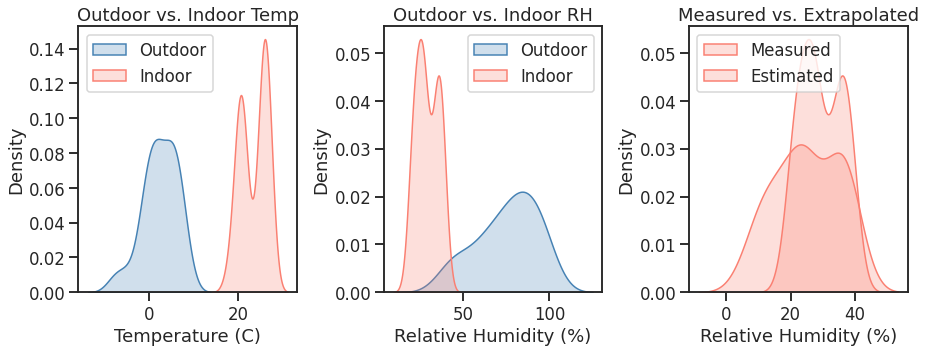

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(13,5))
sns.kdeplot(outdoor_T,fill=True,label='Outdoor',color=outdoor_color,ax=ax[0]); 
sns.kdeplot(indoor_T,fill=True,label='Indoor',color=indoor_color,ax=ax[0])
ax[0].legend(loc='upper left'); ax[0].set_title('Outdoor vs. Indoor Temp'); ax[0].set_xlabel('Temperature (C)')

sns.kdeplot(outdoor_RH,fill=True,label='Outdoor',color=outdoor_color,ax=ax[1]); 
sns.kdeplot(indoor_RH,fill=True,label='Indoor',color=indoor_color,ax=ax[1])
ax[1].legend(loc='upper right'); ax[1].set_title('Outdoor vs. Indoor RH'); ax[1].set_xlabel('Relative Humidity (%)')

sns.kdeplot(indoor_RH,fill=True,label='Measured',color=indoor_color,ax=ax[2],); 
sns.kdeplot(ext_RH,fill=True,label='Estimated',color=indoor_color,ax=ax[2])
ax[2].legend(loc='upper left'); ax[2].set_title('Measured vs. Extrapolated'); ax[2].set_xlabel('Relative Humidity (%)')

fig.tight_layout()

In [ ]:
from scipy import stats
test_T = stats.mannwhitneyu(outdoor_T,indoor_T)
test_RH = stats.mannwhitneyu(outdoor_RH,indoor_RH)
test_ext = stats.mannwhitneyu(indoor_RH,ext_RH)
test_T, test_RH, test_ext

(MannwhitneyuResult(statistic=0.0, pvalue=1.3306088259494477e-12),
 MannwhitneyuResult(statistic=0.0, pvalue=1.3311004625083499e-12),
 MannwhitneyuResult(statistic=456.0, pvalue=0.037300481481050564))

In [ ]:
measured_list = [indoor_longRH['Indoor RH'].mean(), 
                     in_vs_out['Indoor RH'].mean(), 
                     l11_in_vs_out['Indoor RH'].mean(), 
                     l0_in_vs_out['Indoor RH'].mean(), 
                     l2_in_vs_out['Indoor RH'].mean()]

extrapolated_list = [bos_outdoor['in_RH_CALC_1'].mean(), 
                     cam3['in_RH_CALC_1'].mean(), 
                     cam_11['in_RH_CALC_1'].mean(), 
                     cam_0['in_RH_CALC_1'].mean(), 
                     cam['in_RH_CALC_1'].mean()]

final = pd.DataFrame(data=[measured_list,extrapolated_list],index=['Measured','Extrapolated']).T; final['RawError'] = final['Measured']-final['Extrapolated']
final

Measured  Extrapolated   RawError
0  26.166667     27.835582  -1.668915
1  23.721937     16.861217   6.860720
2  35.215933     29.173189   6.042744
3  38.029853     22.975534  15.054319
4  25.226694     25.554477  -0.327782

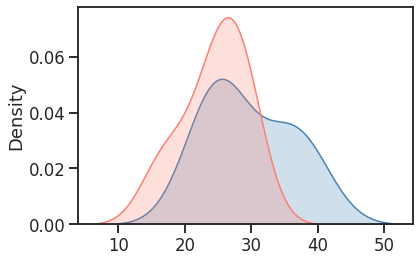

In [ ]:
sns.kdeplot(measured_list,fill=True,color=outdoor_color)
sns.kdeplot(extrapolated_list,fill=True,color=indoor_color)

In [ ]:
test_ext_final = stats.mannwhitneyu(measured_list,extrapolated_list)
test_ext_final

MannwhitneyuResult(statistic=8.0, pvalue=0.20169765244631416)

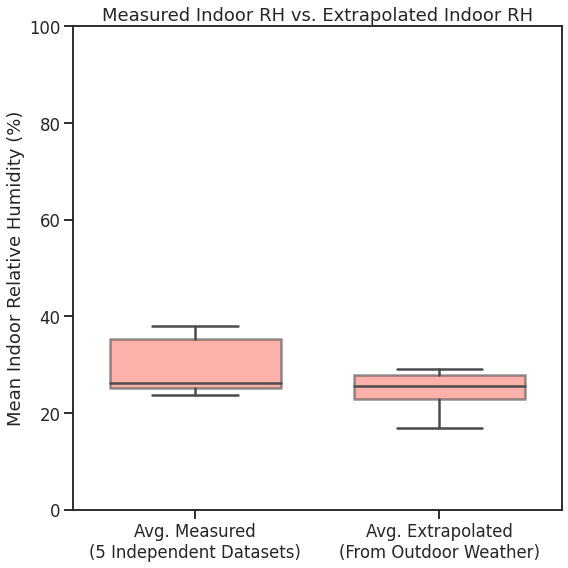

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

alpha = 0.6; s=20; linewidth=2.5; width=0.7; outdoor_color = 'steelblue'; indoor_color = 'salmon'

sns.boxplot(data=final, width=width,linewidth=linewidth)

ax.set_ylim(0,100); ax.set_ylabel('Mean Indoor Relative Humidity (%)'); ax.set_xlabel('')
ax.set_title('Measured Indoor RH vs. Extrapolated Indoor RH')
ax.set_xticklabels(['Avg. Measured\n(5 Independent Datasets)','Avg. Extrapolated\n(From Outdoor Weather)',])
    
[patch.set_alpha(alpha) for patch in ax.artists]
[ax.artists[i].set_facecolor(indoor_color) for i in range(0,2)]

fig.tight_layout()

In [ ]:
# Use StatsModels' CompareMeans to calculate the 95% confidence interval for the difference between means

import statsmodels.stats.api as sms

print('Mean indoor relative humidity measured by indoor sensors:',round(final['Measured'].mean(),2),'+/-',round( final['Measured'].std(),2))

print('\nMedian indoor relative humidity measured by indoor sensors:',round(final['Measured'].median(),2))


print('\nMean indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(final['Extrapolated'].mean(),2),'+/-',round(final['Extrapolated'].std(),2))

print('\nMedian indoor relative humidity estimated by extrapolation workflow from outdoor weather:',round(final['Extrapolated'].median(),2),'+/-')


print('\nAverage difference in means between measured and extrapolated:',round(final['RawError'].mean(),2))

print('\n95% confidence intervals for difference in means between measured and extrapolated:',round(sms.DescrStatsW(final['RawError'].dropna()).tconfint_mean()[0],2),'to',round(sms.DescrStatsW(final['RawError'].dropna()).tconfint_mean()[1],2))


Mean indoor relative humidity measured by indoor sensors: 29.67 +/- 6.48

Median indoor relative humidity measured by indoor sensors: 26.17

Mean indoor relative humidity estimated by extrapolation workflow from outdoor weather: 24.48 +/- 4.87

Median indoor relative humidity estimated by extrapolation workflow from outdoor weather: 25.55 +/-

Average difference in means between measured and extrapolated: 5.19

95% confidence intervals for difference in means between measured and extrapolated: -3.1 to 13.48
